In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "int98"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 219
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 291
Categorical Columns: 8


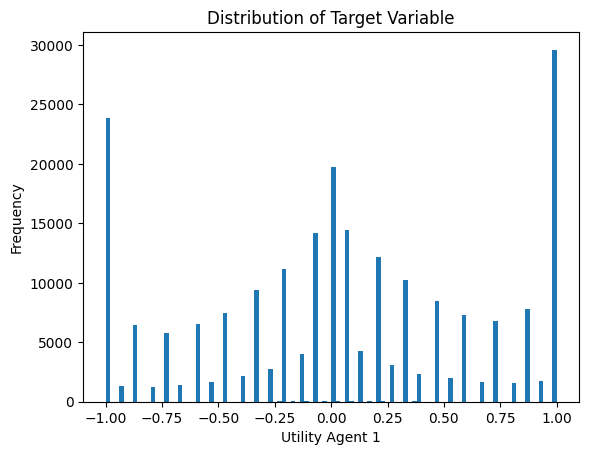

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.493339


[200]	valid_0's rmse: 0.475901


[300]	valid_0's rmse: 0.465928


[400]	valid_0's rmse: 0.458739


[500]	valid_0's rmse: 0.4537


[600]	valid_0's rmse: 0.450077


[700]	valid_0's rmse: 0.446821


[800]	valid_0's rmse: 0.444083


[900]	valid_0's rmse: 0.441391


[1000]	valid_0's rmse: 0.439479


[1100]	valid_0's rmse: 0.437871


[1200]	valid_0's rmse: 0.43645


[1300]	valid_0's rmse: 0.435455


[1400]	valid_0's rmse: 0.434234


[1500]	valid_0's rmse: 0.433321


[1600]	valid_0's rmse: 0.432465


[1700]	valid_0's rmse: 0.4316


[1800]	valid_0's rmse: 0.431144


[1900]	valid_0's rmse: 0.430526


[2000]	valid_0's rmse: 0.430086


[2100]	valid_0's rmse: 0.429624


[2200]	valid_0's rmse: 0.429275


[2300]	valid_0's rmse: 0.428886


[2400]	valid_0's rmse: 0.428434


[2500]	valid_0's rmse: 0.428015


[2600]	valid_0's rmse: 0.427722


[2700]	valid_0's rmse: 0.427446


[2800]	valid_0's rmse: 0.427079


[2900]	valid_0's rmse: 0.426717


[3000]	valid_0's rmse: 0.426585


[3100]	valid_0's rmse: 0.426343


[3200]	valid_0's rmse: 0.426119


[3300]	valid_0's rmse: 0.425902


[3400]	valid_0's rmse: 0.425724


[3500]	valid_0's rmse: 0.425526


[3600]	valid_0's rmse: 0.425326


[3700]	valid_0's rmse: 0.425169


[3800]	valid_0's rmse: 0.425062


[3900]	valid_0's rmse: 0.424817


[4000]	valid_0's rmse: 0.424733


[4100]	valid_0's rmse: 0.424613


[4200]	valid_0's rmse: 0.424579


[4300]	valid_0's rmse: 0.424503


[4400]	valid_0's rmse: 0.424386


[4500]	valid_0's rmse: 0.424339


[4600]	valid_0's rmse: 0.424246


[4700]	valid_0's rmse: 0.424179


[4800]	valid_0's rmse: 0.424028


[4900]	valid_0's rmse: 0.423938


[5000]	valid_0's rmse: 0.423891


[5100]	valid_0's rmse: 0.423911


[5200]	valid_0's rmse: 0.423828


[5300]	valid_0's rmse: 0.423722


[5400]	valid_0's rmse: 0.423605


[5500]	valid_0's rmse: 0.423587


[5600]	valid_0's rmse: 0.423559


[5700]	valid_0's rmse: 0.423485


[5800]	valid_0's rmse: 0.423417


[5900]	valid_0's rmse: 0.423394


[6000]	valid_0's rmse: 0.423284


[6100]	valid_0's rmse: 0.423301


[6200]	valid_0's rmse: 0.423197


[6300]	valid_0's rmse: 0.423143


[6400]	valid_0's rmse: 0.423055


[6500]	valid_0's rmse: 0.422996


[6600]	valid_0's rmse: 0.422976


[6700]	valid_0's rmse: 0.423005


[6800]	valid_0's rmse: 0.422972


[6900]	valid_0's rmse: 0.422975


[7000]	valid_0's rmse: 0.422912


[7100]	valid_0's rmse: 0.422869


[7200]	valid_0's rmse: 0.422891


[7300]	valid_0's rmse: 0.422842


[7400]	valid_0's rmse: 0.422827


[7500]	valid_0's rmse: 0.422805


[7600]	valid_0's rmse: 0.42279


[7700]	valid_0's rmse: 0.422796


[7800]	valid_0's rmse: 0.422748


[7900]	valid_0's rmse: 0.422808


[8000]	valid_0's rmse: 0.422795


[8100]	valid_0's rmse: 0.422746


[8200]	valid_0's rmse: 0.422779


[8300]	valid_0's rmse: 0.422827


[8400]	valid_0's rmse: 0.422829


[8500]	valid_0's rmse: 0.422856


[8600]	valid_0's rmse: 0.422892


[8700]	valid_0's rmse: 0.422859


[8800]	valid_0's rmse: 0.422853


[8900]	valid_0's rmse: 0.422838


[9000]	valid_0's rmse: 0.422862


[9100]	valid_0's rmse: 0.422881


[9200]	valid_0's rmse: 0.422872


[9300]	valid_0's rmse: 0.422887


[9400]	valid_0's rmse: 0.422844


[9500]	valid_0's rmse: 0.422836


[9600]	valid_0's rmse: 0.422807


[9700]	valid_0's rmse: 0.422795


[9800]	valid_0's rmse: 0.42281


[9900]	valid_0's rmse: 0.422828


[10000]	valid_0's rmse: 0.422754


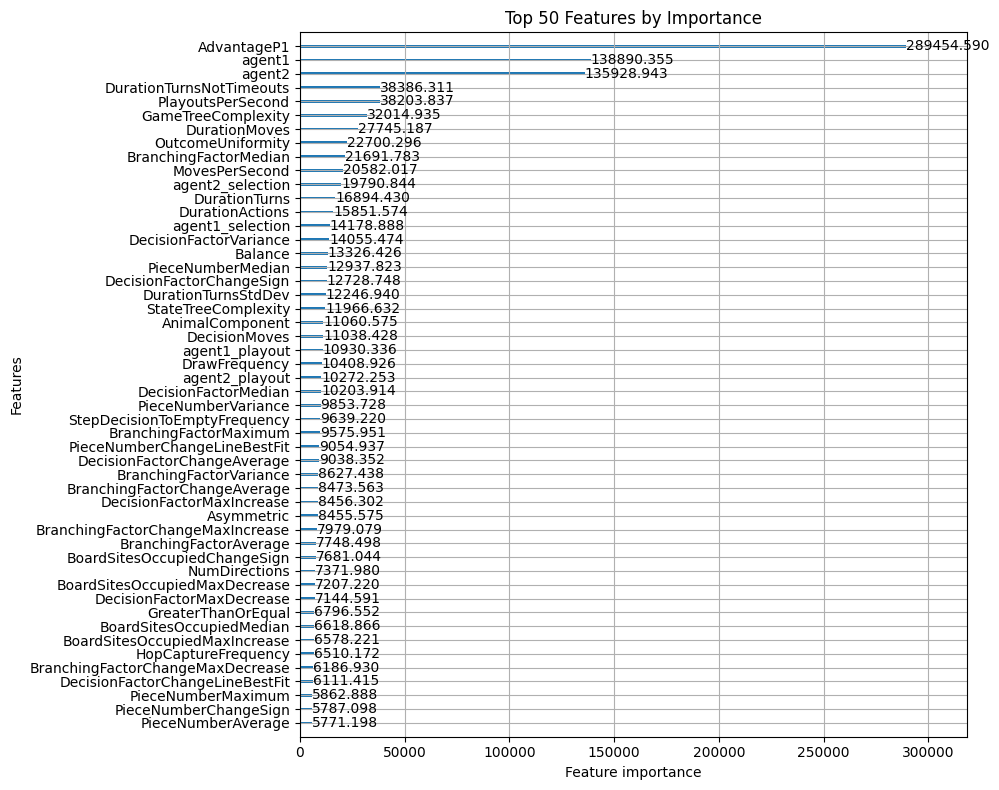

Fold 1 - RMSE: 0.4222392233939478
Fold 2


[100]	valid_0's rmse: 0.511501


[200]	valid_0's rmse: 0.493571


[300]	valid_0's rmse: 0.484607


[400]	valid_0's rmse: 0.479133


[500]	valid_0's rmse: 0.475214


[600]	valid_0's rmse: 0.4713


[700]	valid_0's rmse: 0.46868


[800]	valid_0's rmse: 0.466542


[900]	valid_0's rmse: 0.465255


[1000]	valid_0's rmse: 0.463758


[1100]	valid_0's rmse: 0.462577


[1200]	valid_0's rmse: 0.461567


[1300]	valid_0's rmse: 0.460617


[1400]	valid_0's rmse: 0.45988


[1500]	valid_0's rmse: 0.459149


[1600]	valid_0's rmse: 0.458854


[1700]	valid_0's rmse: 0.458361


[1800]	valid_0's rmse: 0.457833


[1900]	valid_0's rmse: 0.457433


[2000]	valid_0's rmse: 0.457059


[2100]	valid_0's rmse: 0.456557


[2200]	valid_0's rmse: 0.456122


[2300]	valid_0's rmse: 0.455756


[2400]	valid_0's rmse: 0.455513


[2500]	valid_0's rmse: 0.455243


[2600]	valid_0's rmse: 0.454923


[2700]	valid_0's rmse: 0.454653


[2800]	valid_0's rmse: 0.454553


[2900]	valid_0's rmse: 0.454292


[3000]	valid_0's rmse: 0.454043


[3100]	valid_0's rmse: 0.453814


[3200]	valid_0's rmse: 0.45358


[3300]	valid_0's rmse: 0.453468


[3400]	valid_0's rmse: 0.453307


[3500]	valid_0's rmse: 0.453095


[3600]	valid_0's rmse: 0.452906


[3700]	valid_0's rmse: 0.452778


[3800]	valid_0's rmse: 0.452623


[3900]	valid_0's rmse: 0.452412


[4000]	valid_0's rmse: 0.452194


[4100]	valid_0's rmse: 0.452049


[4200]	valid_0's rmse: 0.451992


[4300]	valid_0's rmse: 0.451912


[4400]	valid_0's rmse: 0.451785


[4500]	valid_0's rmse: 0.451725


[4600]	valid_0's rmse: 0.451641


[4700]	valid_0's rmse: 0.451502


[4800]	valid_0's rmse: 0.451469


[4900]	valid_0's rmse: 0.451386


[5000]	valid_0's rmse: 0.451339


[5100]	valid_0's rmse: 0.451331


[5200]	valid_0's rmse: 0.451368


[5300]	valid_0's rmse: 0.451316


[5400]	valid_0's rmse: 0.451185


[5500]	valid_0's rmse: 0.451211


[5600]	valid_0's rmse: 0.451255


[5700]	valid_0's rmse: 0.451173


[5800]	valid_0's rmse: 0.451166


[5900]	valid_0's rmse: 0.45103


[6000]	valid_0's rmse: 0.450924


[6100]	valid_0's rmse: 0.450912


[6200]	valid_0's rmse: 0.450899


[6300]	valid_0's rmse: 0.45083


[6400]	valid_0's rmse: 0.450768


[6500]	valid_0's rmse: 0.450717


[6600]	valid_0's rmse: 0.45069


[6700]	valid_0's rmse: 0.450615


[6800]	valid_0's rmse: 0.450638


[6900]	valid_0's rmse: 0.450481


[7000]	valid_0's rmse: 0.450422


[7100]	valid_0's rmse: 0.450339


[7200]	valid_0's rmse: 0.450328


[7300]	valid_0's rmse: 0.450257


[7400]	valid_0's rmse: 0.450199


[7500]	valid_0's rmse: 0.450179


[7600]	valid_0's rmse: 0.450168


[7700]	valid_0's rmse: 0.450139


[7800]	valid_0's rmse: 0.450111


[7900]	valid_0's rmse: 0.450026


[8000]	valid_0's rmse: 0.449948


[8100]	valid_0's rmse: 0.449958


[8200]	valid_0's rmse: 0.449901


[8300]	valid_0's rmse: 0.44983


[8400]	valid_0's rmse: 0.449727


[8500]	valid_0's rmse: 0.449655


[8600]	valid_0's rmse: 0.449595


[8700]	valid_0's rmse: 0.449556


[8800]	valid_0's rmse: 0.449569


[8900]	valid_0's rmse: 0.449513


[9000]	valid_0's rmse: 0.449497


[9100]	valid_0's rmse: 0.449458


[9200]	valid_0's rmse: 0.449391


[9300]	valid_0's rmse: 0.449337


[9400]	valid_0's rmse: 0.449295


[9500]	valid_0's rmse: 0.449261


[9600]	valid_0's rmse: 0.449218


[9700]	valid_0's rmse: 0.449192


[9800]	valid_0's rmse: 0.44917


[9900]	valid_0's rmse: 0.449155


[10000]	valid_0's rmse: 0.449122


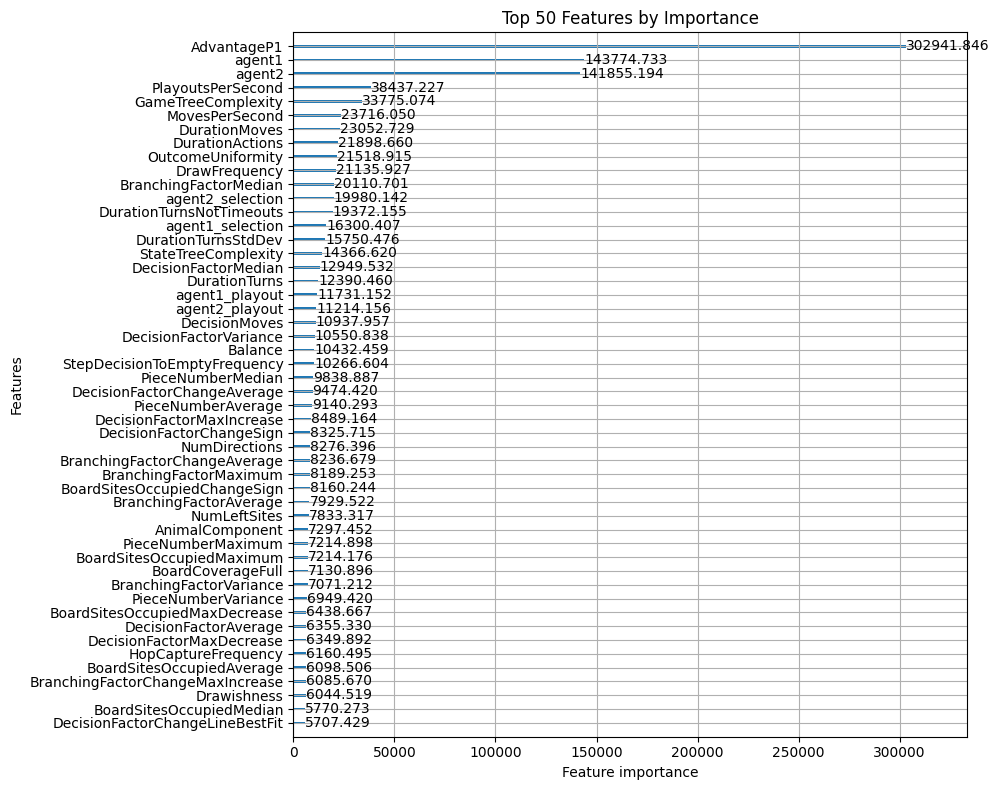

Fold 2 - RMSE: 0.4484935436340062
Fold 3


[100]	valid_0's rmse: 0.512831


[200]	valid_0's rmse: 0.484965


[300]	valid_0's rmse: 0.473998


[400]	valid_0's rmse: 0.466676


[500]	valid_0's rmse: 0.463667


[600]	valid_0's rmse: 0.460727


[700]	valid_0's rmse: 0.458429


[800]	valid_0's rmse: 0.455583


[900]	valid_0's rmse: 0.453594


[1000]	valid_0's rmse: 0.451744


[1100]	valid_0's rmse: 0.450547


[1200]	valid_0's rmse: 0.449432


[1300]	valid_0's rmse: 0.448525


[1400]	valid_0's rmse: 0.447742


[1500]	valid_0's rmse: 0.44704


[1600]	valid_0's rmse: 0.446391


[1700]	valid_0's rmse: 0.445669


[1800]	valid_0's rmse: 0.445075


[1900]	valid_0's rmse: 0.444542


[2000]	valid_0's rmse: 0.444326


[2100]	valid_0's rmse: 0.443952


[2200]	valid_0's rmse: 0.443504


[2300]	valid_0's rmse: 0.443149


[2400]	valid_0's rmse: 0.442965


[2500]	valid_0's rmse: 0.442577


[2600]	valid_0's rmse: 0.442402


[2700]	valid_0's rmse: 0.442225


[2800]	valid_0's rmse: 0.441844


[2900]	valid_0's rmse: 0.44158


[3000]	valid_0's rmse: 0.441405


[3100]	valid_0's rmse: 0.441163


[3200]	valid_0's rmse: 0.440938


[3300]	valid_0's rmse: 0.440735


[3400]	valid_0's rmse: 0.440538


[3500]	valid_0's rmse: 0.440339


[3600]	valid_0's rmse: 0.440192


[3700]	valid_0's rmse: 0.440102


[3800]	valid_0's rmse: 0.439972


[3900]	valid_0's rmse: 0.439679


[4000]	valid_0's rmse: 0.439489


[4100]	valid_0's rmse: 0.439337


[4200]	valid_0's rmse: 0.439322


[4300]	valid_0's rmse: 0.4392


[4400]	valid_0's rmse: 0.439141


[4500]	valid_0's rmse: 0.439063


[4600]	valid_0's rmse: 0.438906


[4700]	valid_0's rmse: 0.438736


[4800]	valid_0's rmse: 0.438518


[4900]	valid_0's rmse: 0.438422


[5000]	valid_0's rmse: 0.438289


[5100]	valid_0's rmse: 0.43818


[5200]	valid_0's rmse: 0.43809


[5300]	valid_0's rmse: 0.438058


[5400]	valid_0's rmse: 0.438043


[5500]	valid_0's rmse: 0.437974


[5600]	valid_0's rmse: 0.437847


[5700]	valid_0's rmse: 0.437843


[5800]	valid_0's rmse: 0.43783


[5900]	valid_0's rmse: 0.437724


[6000]	valid_0's rmse: 0.437741


[6100]	valid_0's rmse: 0.43773


[6200]	valid_0's rmse: 0.437626


[6300]	valid_0's rmse: 0.437558


[6400]	valid_0's rmse: 0.437485


[6500]	valid_0's rmse: 0.437419


[6600]	valid_0's rmse: 0.437379


[6700]	valid_0's rmse: 0.437391


[6800]	valid_0's rmse: 0.437367


[6900]	valid_0's rmse: 0.43731


[7000]	valid_0's rmse: 0.437261


[7100]	valid_0's rmse: 0.437228


[7200]	valid_0's rmse: 0.437217


[7300]	valid_0's rmse: 0.437199


[7400]	valid_0's rmse: 0.437149


[7500]	valid_0's rmse: 0.437094


[7600]	valid_0's rmse: 0.437017


[7700]	valid_0's rmse: 0.436963


[7800]	valid_0's rmse: 0.436932


[7900]	valid_0's rmse: 0.436881


[8000]	valid_0's rmse: 0.436945


[8100]	valid_0's rmse: 0.43698


[8200]	valid_0's rmse: 0.436987


[8300]	valid_0's rmse: 0.436969


[8400]	valid_0's rmse: 0.436962


[8500]	valid_0's rmse: 0.436939


[8600]	valid_0's rmse: 0.43689


[8700]	valid_0's rmse: 0.43686


[8800]	valid_0's rmse: 0.43685


[8900]	valid_0's rmse: 0.436906


[9000]	valid_0's rmse: 0.436855


[9100]	valid_0's rmse: 0.436862


[9200]	valid_0's rmse: 0.436812


[9300]	valid_0's rmse: 0.43677


[9400]	valid_0's rmse: 0.43675


[9500]	valid_0's rmse: 0.436728


[9600]	valid_0's rmse: 0.436697


[9700]	valid_0's rmse: 0.436646


[9800]	valid_0's rmse: 0.436637


[9900]	valid_0's rmse: 0.436646


[10000]	valid_0's rmse: 0.436682


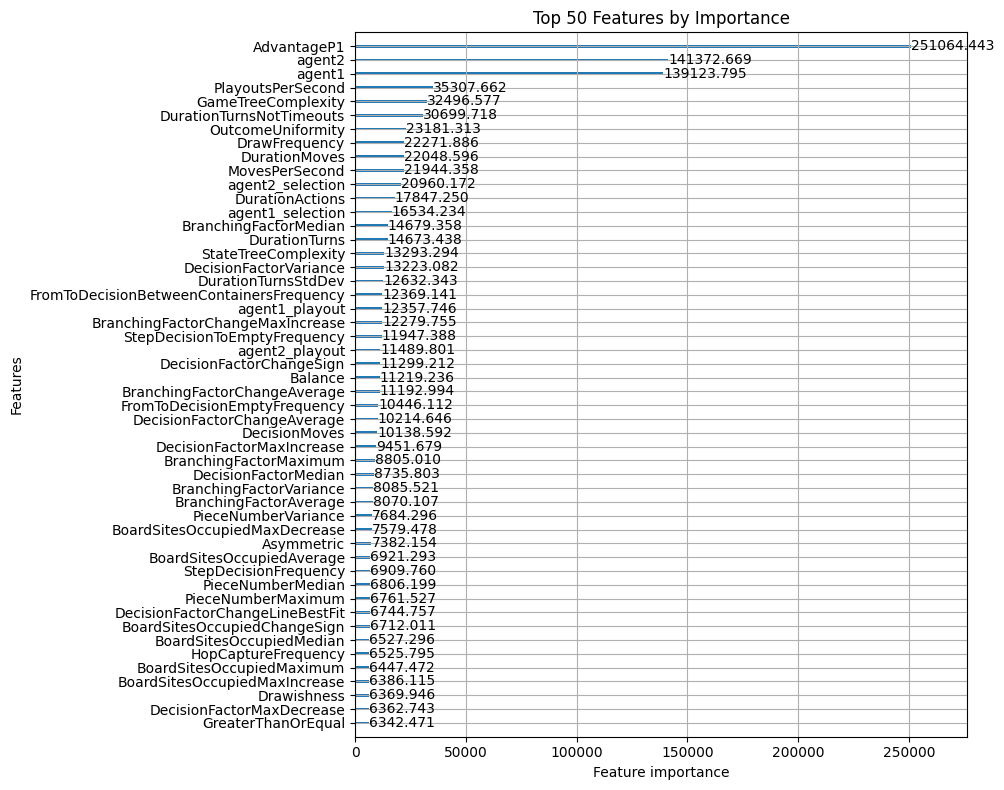

Fold 3 - RMSE: 0.4359557554150202
Fold 4


[100]	valid_0's rmse: 0.513197


[200]	valid_0's rmse: 0.491677


[300]	valid_0's rmse: 0.47854


[400]	valid_0's rmse: 0.47005


[500]	valid_0's rmse: 0.464074


[600]	valid_0's rmse: 0.460275


[700]	valid_0's rmse: 0.456969


[800]	valid_0's rmse: 0.45462


[900]	valid_0's rmse: 0.452969


[1000]	valid_0's rmse: 0.451321


[1100]	valid_0's rmse: 0.449869


[1200]	valid_0's rmse: 0.448638


[1300]	valid_0's rmse: 0.447778


[1400]	valid_0's rmse: 0.446876


[1500]	valid_0's rmse: 0.446267


[1600]	valid_0's rmse: 0.445652


[1700]	valid_0's rmse: 0.444945


[1800]	valid_0's rmse: 0.444263


[1900]	valid_0's rmse: 0.443873


[2000]	valid_0's rmse: 0.443296


[2100]	valid_0's rmse: 0.442885


[2200]	valid_0's rmse: 0.442326


[2300]	valid_0's rmse: 0.44203


[2400]	valid_0's rmse: 0.441749


[2500]	valid_0's rmse: 0.441446


[2600]	valid_0's rmse: 0.441154


[2700]	valid_0's rmse: 0.440927


[2800]	valid_0's rmse: 0.440589


[2900]	valid_0's rmse: 0.440248


[3000]	valid_0's rmse: 0.440065


[3100]	valid_0's rmse: 0.439816


[3200]	valid_0's rmse: 0.439646


[3300]	valid_0's rmse: 0.439396


[3400]	valid_0's rmse: 0.439252


[3500]	valid_0's rmse: 0.43895


[3600]	valid_0's rmse: 0.438784


[3700]	valid_0's rmse: 0.438619


[3800]	valid_0's rmse: 0.438555


[3900]	valid_0's rmse: 0.438339


[4000]	valid_0's rmse: 0.438143


[4100]	valid_0's rmse: 0.438044


[4200]	valid_0's rmse: 0.437898


[4300]	valid_0's rmse: 0.437826


[4400]	valid_0's rmse: 0.437657


[4500]	valid_0's rmse: 0.4375


[4600]	valid_0's rmse: 0.43738


[4700]	valid_0's rmse: 0.437314


[4800]	valid_0's rmse: 0.437176


[4900]	valid_0's rmse: 0.437069


[5000]	valid_0's rmse: 0.437025


[5100]	valid_0's rmse: 0.436913


[5200]	valid_0's rmse: 0.4369


[5300]	valid_0's rmse: 0.436864


[5400]	valid_0's rmse: 0.436808


[5500]	valid_0's rmse: 0.436767


[5600]	valid_0's rmse: 0.436673


[5700]	valid_0's rmse: 0.436555


[5800]	valid_0's rmse: 0.436541


[5900]	valid_0's rmse: 0.436491


[6000]	valid_0's rmse: 0.43646


[6100]	valid_0's rmse: 0.436362


[6200]	valid_0's rmse: 0.436224


[6300]	valid_0's rmse: 0.436151


[6400]	valid_0's rmse: 0.436063


[6500]	valid_0's rmse: 0.43588


[6600]	valid_0's rmse: 0.435849


[6700]	valid_0's rmse: 0.435794


[6800]	valid_0's rmse: 0.435705


[6900]	valid_0's rmse: 0.435692


[7000]	valid_0's rmse: 0.435604


[7100]	valid_0's rmse: 0.43555


[7200]	valid_0's rmse: 0.435463


[7300]	valid_0's rmse: 0.435451


[7400]	valid_0's rmse: 0.435463


[7500]	valid_0's rmse: 0.43547


[7600]	valid_0's rmse: 0.435372


[7700]	valid_0's rmse: 0.43537


[7800]	valid_0's rmse: 0.435392


[7900]	valid_0's rmse: 0.435328


[8000]	valid_0's rmse: 0.435329


[8100]	valid_0's rmse: 0.435282


[8200]	valid_0's rmse: 0.435234


[8300]	valid_0's rmse: 0.435219


[8400]	valid_0's rmse: 0.435195


[8500]	valid_0's rmse: 0.435121


[8600]	valid_0's rmse: 0.435086


[8700]	valid_0's rmse: 0.435092


[8800]	valid_0's rmse: 0.43506


[8900]	valid_0's rmse: 0.435043


[9000]	valid_0's rmse: 0.43504


[9100]	valid_0's rmse: 0.434972


[9200]	valid_0's rmse: 0.434909


[9300]	valid_0's rmse: 0.434866


[9400]	valid_0's rmse: 0.43484


[9500]	valid_0's rmse: 0.434785


[9600]	valid_0's rmse: 0.434776


[9700]	valid_0's rmse: 0.434767


[9800]	valid_0's rmse: 0.434725


[9900]	valid_0's rmse: 0.434712


[10000]	valid_0's rmse: 0.434714


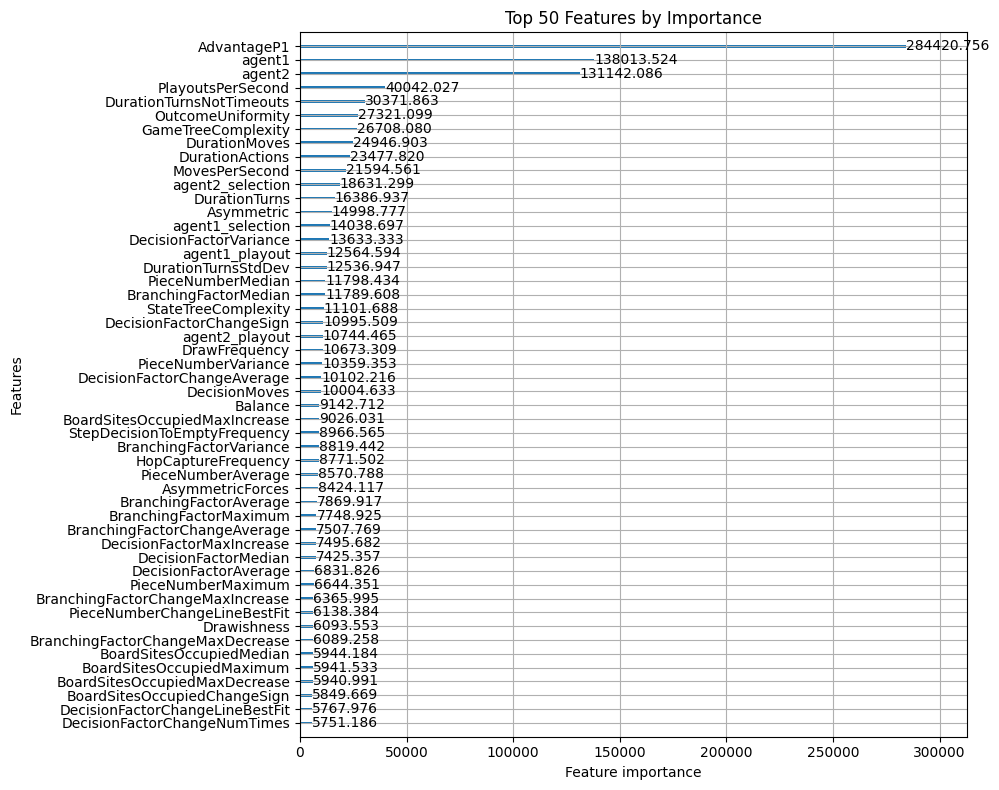

Fold 4 - RMSE: 0.4338717950256658
Fold 5


[100]	valid_0's rmse: 0.486847


[200]	valid_0's rmse: 0.467342


[300]	valid_0's rmse: 0.454245


[400]	valid_0's rmse: 0.445216


[500]	valid_0's rmse: 0.438604


[600]	valid_0's rmse: 0.434073


[700]	valid_0's rmse: 0.430313


[800]	valid_0's rmse: 0.426853


[900]	valid_0's rmse: 0.423938


[1000]	valid_0's rmse: 0.422223


[1100]	valid_0's rmse: 0.420465


[1200]	valid_0's rmse: 0.4192


[1300]	valid_0's rmse: 0.417848


[1400]	valid_0's rmse: 0.416745


[1500]	valid_0's rmse: 0.415767


[1600]	valid_0's rmse: 0.414798


[1700]	valid_0's rmse: 0.414078


[1800]	valid_0's rmse: 0.413193


[1900]	valid_0's rmse: 0.412566


[2000]	valid_0's rmse: 0.411941


[2100]	valid_0's rmse: 0.411337


[2200]	valid_0's rmse: 0.410879


[2300]	valid_0's rmse: 0.410466


[2400]	valid_0's rmse: 0.41012


[2500]	valid_0's rmse: 0.409867


[2600]	valid_0's rmse: 0.409424


[2700]	valid_0's rmse: 0.409197


[2800]	valid_0's rmse: 0.408984


[2900]	valid_0's rmse: 0.408743


[3000]	valid_0's rmse: 0.408405


[3100]	valid_0's rmse: 0.40808


[3200]	valid_0's rmse: 0.407835


[3300]	valid_0's rmse: 0.407615


[3400]	valid_0's rmse: 0.40745


[3500]	valid_0's rmse: 0.407314


[3600]	valid_0's rmse: 0.407157


[3700]	valid_0's rmse: 0.406953


[3800]	valid_0's rmse: 0.406826


[3900]	valid_0's rmse: 0.406679


[4000]	valid_0's rmse: 0.406477


[4100]	valid_0's rmse: 0.406363


[4200]	valid_0's rmse: 0.406153


[4300]	valid_0's rmse: 0.406011


[4400]	valid_0's rmse: 0.405924


[4500]	valid_0's rmse: 0.405835


[4600]	valid_0's rmse: 0.405763


[4700]	valid_0's rmse: 0.405656


[4800]	valid_0's rmse: 0.405608


[4900]	valid_0's rmse: 0.405534


[5000]	valid_0's rmse: 0.405478


[5100]	valid_0's rmse: 0.405475


[5200]	valid_0's rmse: 0.405415


[5300]	valid_0's rmse: 0.405298


[5400]	valid_0's rmse: 0.405295


[5500]	valid_0's rmse: 0.40523


[5600]	valid_0's rmse: 0.405207


[5700]	valid_0's rmse: 0.405056


[5800]	valid_0's rmse: 0.405089


[5900]	valid_0's rmse: 0.405015


[6000]	valid_0's rmse: 0.404918


[6100]	valid_0's rmse: 0.404907


[6200]	valid_0's rmse: 0.404897


[6300]	valid_0's rmse: 0.404827


[6400]	valid_0's rmse: 0.404778


[6500]	valid_0's rmse: 0.404726


[6600]	valid_0's rmse: 0.404751


[6700]	valid_0's rmse: 0.404712


[6800]	valid_0's rmse: 0.404722


[6900]	valid_0's rmse: 0.404677


[7000]	valid_0's rmse: 0.404635


[7100]	valid_0's rmse: 0.404641


[7200]	valid_0's rmse: 0.404645


[7300]	valid_0's rmse: 0.404627


[7400]	valid_0's rmse: 0.404579


[7500]	valid_0's rmse: 0.40462


[7600]	valid_0's rmse: 0.404635


[7700]	valid_0's rmse: 0.404621


[7800]	valid_0's rmse: 0.4046


[7900]	valid_0's rmse: 0.40449


[8000]	valid_0's rmse: 0.404481


[8100]	valid_0's rmse: 0.404386


[8200]	valid_0's rmse: 0.40436


[8300]	valid_0's rmse: 0.404373


[8400]	valid_0's rmse: 0.404351


[8500]	valid_0's rmse: 0.404276


[8600]	valid_0's rmse: 0.404231


[8700]	valid_0's rmse: 0.404228


[8800]	valid_0's rmse: 0.404169


[8900]	valid_0's rmse: 0.404135


[9000]	valid_0's rmse: 0.404151


[9100]	valid_0's rmse: 0.404119


[9200]	valid_0's rmse: 0.404093


[9300]	valid_0's rmse: 0.404094


[9400]	valid_0's rmse: 0.404031


[9500]	valid_0's rmse: 0.404005


[9600]	valid_0's rmse: 0.404057


[9700]	valid_0's rmse: 0.404042


[9800]	valid_0's rmse: 0.404084


[9900]	valid_0's rmse: 0.404014


[10000]	valid_0's rmse: 0.404025


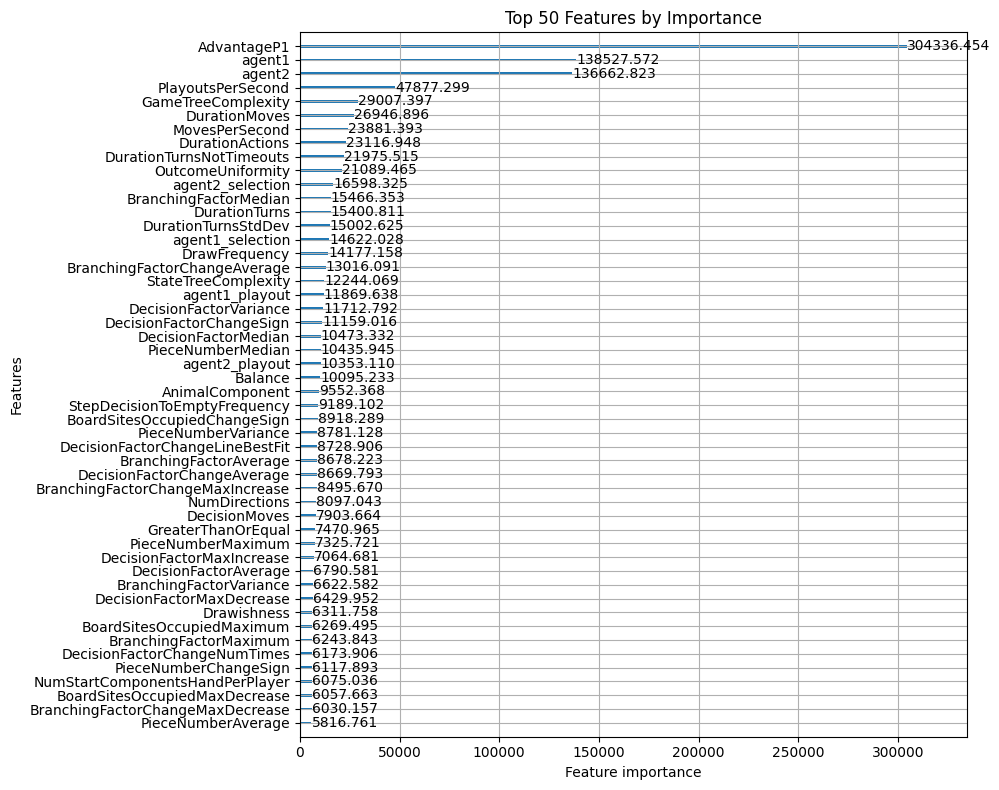

Fold 5 - RMSE: 0.40361845438916455
List of oof scores: [0.4222392233939478, 0.4484935436340062, 0.4359557554150202, 0.4338717950256658, 0.40361845438916455]
Average oof score: 0.4288357543715609


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.476323


[200]	valid_0's rmse: 0.456787


[300]	valid_0's rmse: 0.447051


[400]	valid_0's rmse: 0.441068


[500]	valid_0's rmse: 0.437517


[600]	valid_0's rmse: 0.433763


[700]	valid_0's rmse: 0.430633


[800]	valid_0's rmse: 0.428454


[900]	valid_0's rmse: 0.426926


[1000]	valid_0's rmse: 0.425697


[1100]	valid_0's rmse: 0.4243


[1200]	valid_0's rmse: 0.423406


[1300]	valid_0's rmse: 0.422391


[1400]	valid_0's rmse: 0.42167


[1500]	valid_0's rmse: 0.421101


[1600]	valid_0's rmse: 0.420342


[1700]	valid_0's rmse: 0.419847


[1800]	valid_0's rmse: 0.419208


[1900]	valid_0's rmse: 0.418611


[2000]	valid_0's rmse: 0.418309


[2100]	valid_0's rmse: 0.417831


[2200]	valid_0's rmse: 0.417474


[2300]	valid_0's rmse: 0.417017


[2400]	valid_0's rmse: 0.416773


[2500]	valid_0's rmse: 0.416418


[2600]	valid_0's rmse: 0.416145


[2700]	valid_0's rmse: 0.415979


[2800]	valid_0's rmse: 0.415808


[2900]	valid_0's rmse: 0.415606


[3000]	valid_0's rmse: 0.415467


[3100]	valid_0's rmse: 0.415036


[3200]	valid_0's rmse: 0.41484


[3300]	valid_0's rmse: 0.414658


[3400]	valid_0's rmse: 0.414417


[3500]	valid_0's rmse: 0.414284


[3600]	valid_0's rmse: 0.414034


[3700]	valid_0's rmse: 0.413943


[3800]	valid_0's rmse: 0.413849


[3900]	valid_0's rmse: 0.413835


[4000]	valid_0's rmse: 0.413784


[4100]	valid_0's rmse: 0.413561


[4200]	valid_0's rmse: 0.41347


[4300]	valid_0's rmse: 0.413355


[4400]	valid_0's rmse: 0.413283


[4500]	valid_0's rmse: 0.413129


[4600]	valid_0's rmse: 0.413027


[4700]	valid_0's rmse: 0.412985


[4800]	valid_0's rmse: 0.412869


[4900]	valid_0's rmse: 0.412758


[5000]	valid_0's rmse: 0.412641


[5100]	valid_0's rmse: 0.412485


[5200]	valid_0's rmse: 0.412317


[5300]	valid_0's rmse: 0.412239


[5400]	valid_0's rmse: 0.412166


[5500]	valid_0's rmse: 0.412074


[5600]	valid_0's rmse: 0.412053


[5700]	valid_0's rmse: 0.41202


[5800]	valid_0's rmse: 0.411938


[5900]	valid_0's rmse: 0.41188


[6000]	valid_0's rmse: 0.411812


[6100]	valid_0's rmse: 0.411766


[6200]	valid_0's rmse: 0.411672


[6300]	valid_0's rmse: 0.411572


[6400]	valid_0's rmse: 0.411495


[6500]	valid_0's rmse: 0.411447


[6600]	valid_0's rmse: 0.411413


[6700]	valid_0's rmse: 0.411386


[6800]	valid_0's rmse: 0.411371


[6900]	valid_0's rmse: 0.411298


[7000]	valid_0's rmse: 0.41131


[7100]	valid_0's rmse: 0.411287


[7200]	valid_0's rmse: 0.411259


[7300]	valid_0's rmse: 0.41127


[7400]	valid_0's rmse: 0.411231


[7500]	valid_0's rmse: 0.411213


[7600]	valid_0's rmse: 0.411144


[7700]	valid_0's rmse: 0.411119


[7800]	valid_0's rmse: 0.411081


[7900]	valid_0's rmse: 0.411059


[8000]	valid_0's rmse: 0.411001


[8100]	valid_0's rmse: 0.410916


[8200]	valid_0's rmse: 0.410928


[8300]	valid_0's rmse: 0.41091


[8400]	valid_0's rmse: 0.410847


[8500]	valid_0's rmse: 0.410786


[8600]	valid_0's rmse: 0.410755


[8700]	valid_0's rmse: 0.410679


[8800]	valid_0's rmse: 0.410683


[8900]	valid_0's rmse: 0.41065


[9000]	valid_0's rmse: 0.410601


[9100]	valid_0's rmse: 0.410617


[9200]	valid_0's rmse: 0.410629


[9300]	valid_0's rmse: 0.410595


[9400]	valid_0's rmse: 0.410632


[9500]	valid_0's rmse: 0.410591


[9600]	valid_0's rmse: 0.410487


[9700]	valid_0's rmse: 0.410442


[9800]	valid_0's rmse: 0.410424


[9900]	valid_0's rmse: 0.410459


[10000]	valid_0's rmse: 0.410419


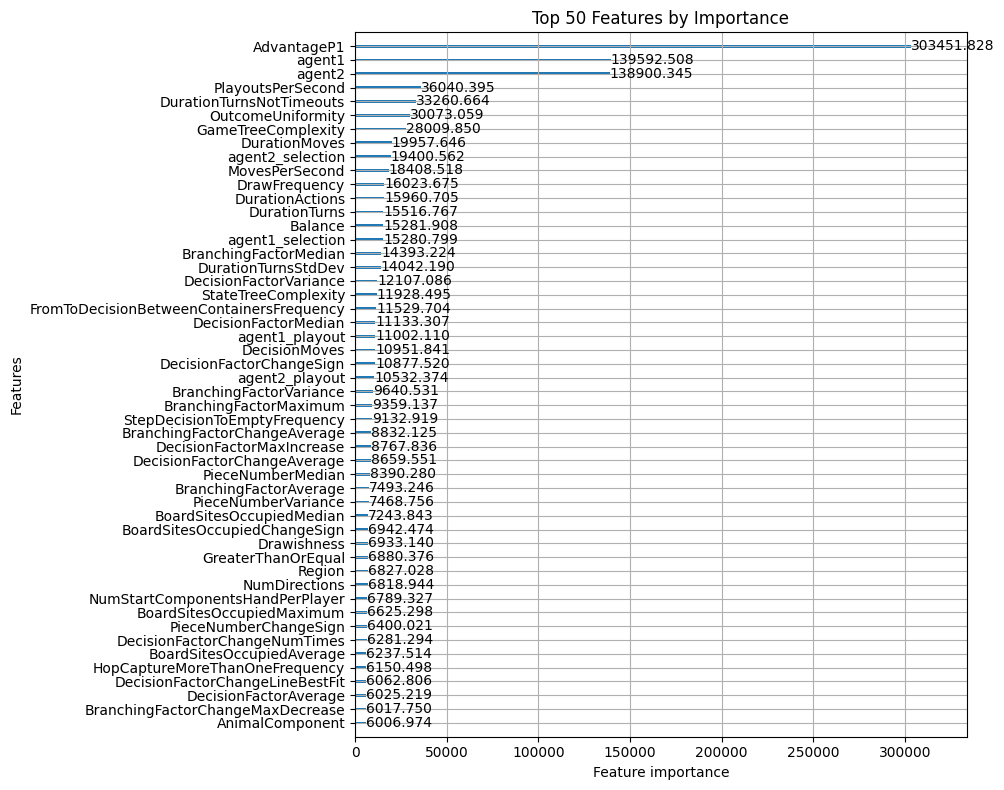

Fold 1 - RMSE: 0.40996211533116306
Fold 2


[100]	valid_0's rmse: 0.460196


[200]	valid_0's rmse: 0.439853


[300]	valid_0's rmse: 0.431333


[400]	valid_0's rmse: 0.425642


[500]	valid_0's rmse: 0.422081


[600]	valid_0's rmse: 0.419599


[700]	valid_0's rmse: 0.41696


[800]	valid_0's rmse: 0.415231


[900]	valid_0's rmse: 0.413474


[1000]	valid_0's rmse: 0.412464


[1100]	valid_0's rmse: 0.41132


[1200]	valid_0's rmse: 0.410429


[1300]	valid_0's rmse: 0.40956


[1400]	valid_0's rmse: 0.408791


[1500]	valid_0's rmse: 0.408166


[1600]	valid_0's rmse: 0.407654


[1700]	valid_0's rmse: 0.40708


[1800]	valid_0's rmse: 0.406626


[1900]	valid_0's rmse: 0.406273


[2000]	valid_0's rmse: 0.406006


[2100]	valid_0's rmse: 0.405843


[2200]	valid_0's rmse: 0.405552


[2300]	valid_0's rmse: 0.405294


[2400]	valid_0's rmse: 0.405214


[2500]	valid_0's rmse: 0.404912


[2600]	valid_0's rmse: 0.40475


[2700]	valid_0's rmse: 0.404624


[2800]	valid_0's rmse: 0.404435


[2900]	valid_0's rmse: 0.404487


[3000]	valid_0's rmse: 0.404386


[3100]	valid_0's rmse: 0.404173


[3200]	valid_0's rmse: 0.404101


[3300]	valid_0's rmse: 0.404054


[3400]	valid_0's rmse: 0.403967


[3500]	valid_0's rmse: 0.403799


[3600]	valid_0's rmse: 0.403773


[3700]	valid_0's rmse: 0.403634


[3800]	valid_0's rmse: 0.403679


[3900]	valid_0's rmse: 0.403642


[4000]	valid_0's rmse: 0.403496


[4100]	valid_0's rmse: 0.403473


[4200]	valid_0's rmse: 0.403382


[4300]	valid_0's rmse: 0.403357


[4400]	valid_0's rmse: 0.403233


[4500]	valid_0's rmse: 0.403183


[4600]	valid_0's rmse: 0.403121


[4700]	valid_0's rmse: 0.403086


[4800]	valid_0's rmse: 0.403081


[4900]	valid_0's rmse: 0.403176


[5000]	valid_0's rmse: 0.403178


[5100]	valid_0's rmse: 0.403086


[5200]	valid_0's rmse: 0.403011


[5300]	valid_0's rmse: 0.402917


[5400]	valid_0's rmse: 0.402895


[5500]	valid_0's rmse: 0.402826


[5600]	valid_0's rmse: 0.402842


[5700]	valid_0's rmse: 0.402835


[5800]	valid_0's rmse: 0.402825


[5900]	valid_0's rmse: 0.402774


[6000]	valid_0's rmse: 0.402798


[6100]	valid_0's rmse: 0.402839


[6200]	valid_0's rmse: 0.402765


[6300]	valid_0's rmse: 0.402804


[6400]	valid_0's rmse: 0.402762


[6500]	valid_0's rmse: 0.402743


[6600]	valid_0's rmse: 0.402784


[6700]	valid_0's rmse: 0.402702


[6800]	valid_0's rmse: 0.402721


[6900]	valid_0's rmse: 0.402705


[7000]	valid_0's rmse: 0.402705


[7100]	valid_0's rmse: 0.402636


[7200]	valid_0's rmse: 0.402628


[7300]	valid_0's rmse: 0.402651


[7400]	valid_0's rmse: 0.402615


[7500]	valid_0's rmse: 0.402589


[7600]	valid_0's rmse: 0.402618


[7700]	valid_0's rmse: 0.402627


[7800]	valid_0's rmse: 0.402672


[7900]	valid_0's rmse: 0.402684


[8000]	valid_0's rmse: 0.402642


[8100]	valid_0's rmse: 0.402709


[8200]	valid_0's rmse: 0.402751


[8300]	valid_0's rmse: 0.402691


[8400]	valid_0's rmse: 0.402661


[8500]	valid_0's rmse: 0.40272


[8600]	valid_0's rmse: 0.402726


[8700]	valid_0's rmse: 0.40274


[8800]	valid_0's rmse: 0.402704


[8900]	valid_0's rmse: 0.40272


[9000]	valid_0's rmse: 0.402741


[9100]	valid_0's rmse: 0.40278


[9200]	valid_0's rmse: 0.402749


[9300]	valid_0's rmse: 0.402739


[9400]	valid_0's rmse: 0.402756


[9500]	valid_0's rmse: 0.402741


[9600]	valid_0's rmse: 0.402734


[9700]	valid_0's rmse: 0.402723


[9800]	valid_0's rmse: 0.402749


[9900]	valid_0's rmse: 0.402726


[10000]	valid_0's rmse: 0.402746


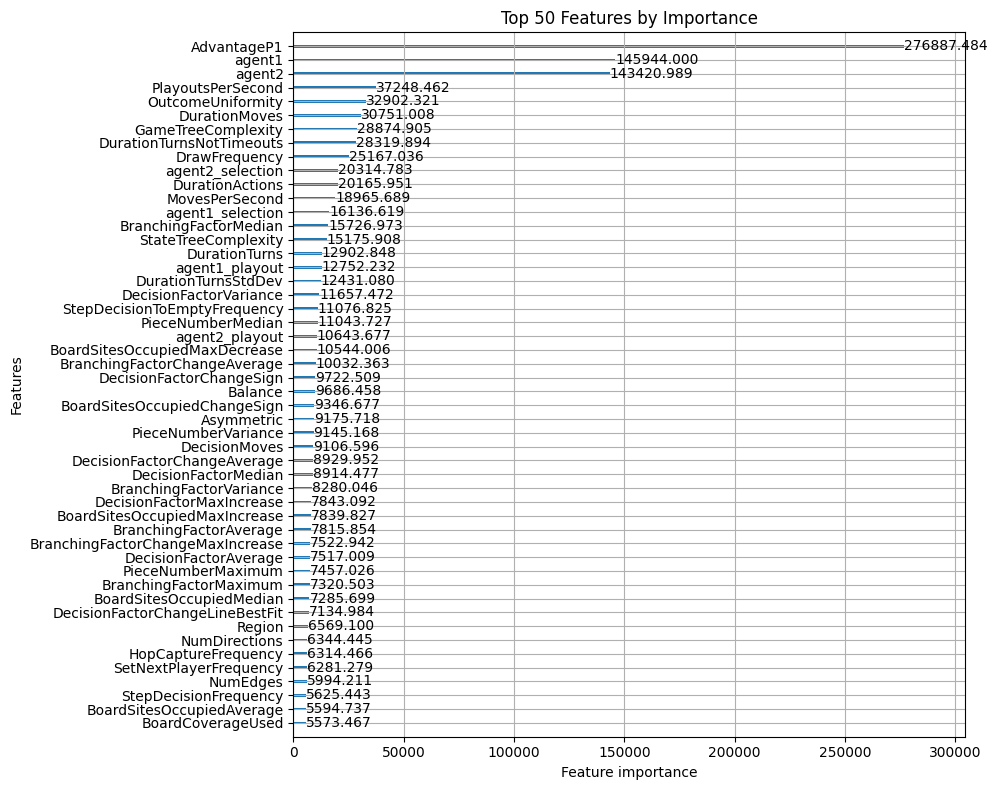

Fold 2 - RMSE: 0.4019397155823597
Fold 3


[100]	valid_0's rmse: 0.525831


[200]	valid_0's rmse: 0.498602


[300]	valid_0's rmse: 0.484819


[400]	valid_0's rmse: 0.47637


[500]	valid_0's rmse: 0.470195


[600]	valid_0's rmse: 0.464782


[700]	valid_0's rmse: 0.461579


[800]	valid_0's rmse: 0.458155


[900]	valid_0's rmse: 0.455688


[1000]	valid_0's rmse: 0.453589


[1100]	valid_0's rmse: 0.452035


[1200]	valid_0's rmse: 0.450428


[1300]	valid_0's rmse: 0.449267


[1400]	valid_0's rmse: 0.448336


[1500]	valid_0's rmse: 0.447347


[1600]	valid_0's rmse: 0.446497


[1700]	valid_0's rmse: 0.445829


[1800]	valid_0's rmse: 0.444934


[1900]	valid_0's rmse: 0.444115


[2000]	valid_0's rmse: 0.443588


[2100]	valid_0's rmse: 0.443142


[2200]	valid_0's rmse: 0.442569


[2300]	valid_0's rmse: 0.442094


[2400]	valid_0's rmse: 0.441571


[2500]	valid_0's rmse: 0.441134


[2600]	valid_0's rmse: 0.440789


[2700]	valid_0's rmse: 0.440484


[2800]	valid_0's rmse: 0.440217


[2900]	valid_0's rmse: 0.439858


[3000]	valid_0's rmse: 0.439548


[3100]	valid_0's rmse: 0.439206


[3200]	valid_0's rmse: 0.438924


[3300]	valid_0's rmse: 0.43868


[3400]	valid_0's rmse: 0.438486


[3500]	valid_0's rmse: 0.438206


[3600]	valid_0's rmse: 0.437955


[3700]	valid_0's rmse: 0.437767


[3800]	valid_0's rmse: 0.437645


[3900]	valid_0's rmse: 0.437431


[4000]	valid_0's rmse: 0.437278


[4100]	valid_0's rmse: 0.437107


[4200]	valid_0's rmse: 0.437044


[4300]	valid_0's rmse: 0.436813


[4400]	valid_0's rmse: 0.436676


[4500]	valid_0's rmse: 0.436553


[4600]	valid_0's rmse: 0.436409


[4700]	valid_0's rmse: 0.436308


[4800]	valid_0's rmse: 0.436078


[4900]	valid_0's rmse: 0.435943


[5000]	valid_0's rmse: 0.435749


[5100]	valid_0's rmse: 0.435595


[5200]	valid_0's rmse: 0.43556


[5300]	valid_0's rmse: 0.435431


[5400]	valid_0's rmse: 0.435378


[5500]	valid_0's rmse: 0.435217


[5600]	valid_0's rmse: 0.435159


[5700]	valid_0's rmse: 0.435082


[5800]	valid_0's rmse: 0.435068


[5900]	valid_0's rmse: 0.435011


[6000]	valid_0's rmse: 0.434932


[6100]	valid_0's rmse: 0.434874


[6200]	valid_0's rmse: 0.434757


[6300]	valid_0's rmse: 0.434696


[6400]	valid_0's rmse: 0.434584


[6500]	valid_0's rmse: 0.434656


[6600]	valid_0's rmse: 0.434603


[6700]	valid_0's rmse: 0.434464


[6800]	valid_0's rmse: 0.434357


[6900]	valid_0's rmse: 0.434329


[7000]	valid_0's rmse: 0.434287


[7100]	valid_0's rmse: 0.434248


[7200]	valid_0's rmse: 0.434277


[7300]	valid_0's rmse: 0.434212


[7400]	valid_0's rmse: 0.434152


[7500]	valid_0's rmse: 0.434098


[7600]	valid_0's rmse: 0.434083


[7700]	valid_0's rmse: 0.433991


[7800]	valid_0's rmse: 0.433976


[7900]	valid_0's rmse: 0.43392


[8000]	valid_0's rmse: 0.433876


[8100]	valid_0's rmse: 0.433818


[8200]	valid_0's rmse: 0.433796


[8300]	valid_0's rmse: 0.433715


[8400]	valid_0's rmse: 0.433643


[8500]	valid_0's rmse: 0.433642


[8600]	valid_0's rmse: 0.433589


[8700]	valid_0's rmse: 0.43354


[8800]	valid_0's rmse: 0.43351


[8900]	valid_0's rmse: 0.433482


[9000]	valid_0's rmse: 0.433441


[9100]	valid_0's rmse: 0.433384


[9200]	valid_0's rmse: 0.433369


[9300]	valid_0's rmse: 0.433359


[9400]	valid_0's rmse: 0.433383


[9500]	valid_0's rmse: 0.433356


[9600]	valid_0's rmse: 0.433316


[9700]	valid_0's rmse: 0.433289


[9800]	valid_0's rmse: 0.43325


[9900]	valid_0's rmse: 0.433163


[10000]	valid_0's rmse: 0.433157


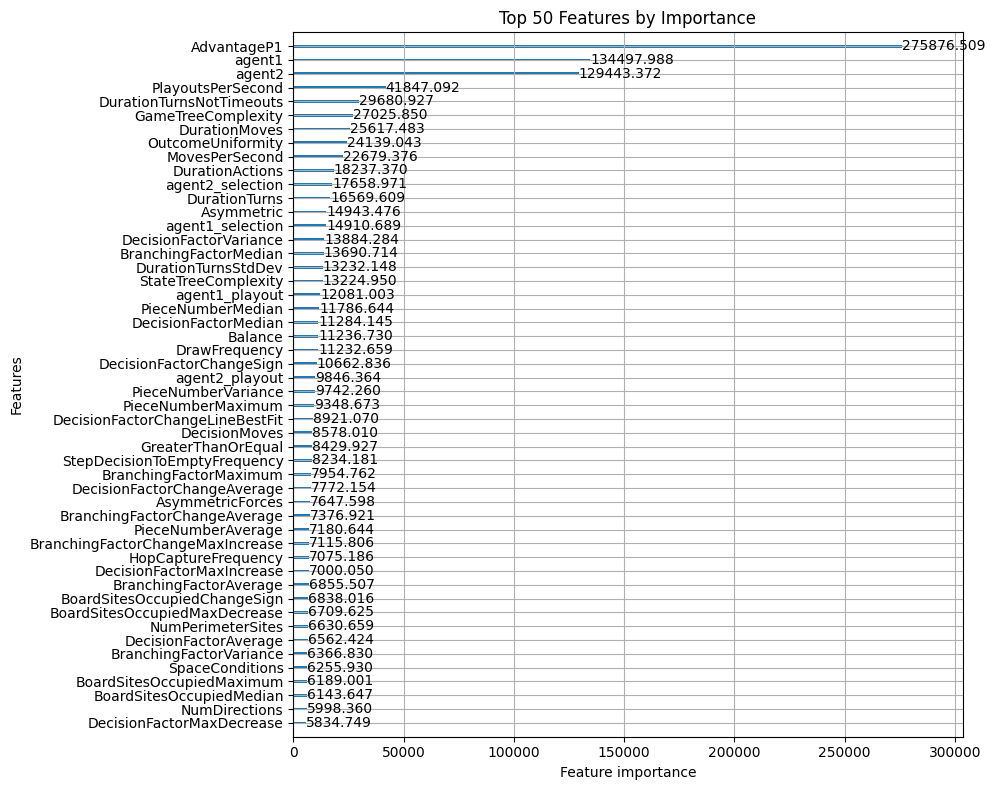

Fold 3 - RMSE: 0.4324641388745906
Fold 4


[100]	valid_0's rmse: 0.519099


[200]	valid_0's rmse: 0.494213


[300]	valid_0's rmse: 0.47966


[400]	valid_0's rmse: 0.472567


[500]	valid_0's rmse: 0.467657


[600]	valid_0's rmse: 0.464769


[700]	valid_0's rmse: 0.461601


[800]	valid_0's rmse: 0.459294


[900]	valid_0's rmse: 0.45736


[1000]	valid_0's rmse: 0.455554


[1100]	valid_0's rmse: 0.454325


[1200]	valid_0's rmse: 0.452929


[1300]	valid_0's rmse: 0.451738


[1400]	valid_0's rmse: 0.450955


[1500]	valid_0's rmse: 0.450106


[1600]	valid_0's rmse: 0.44941


[1700]	valid_0's rmse: 0.448832


[1800]	valid_0's rmse: 0.448274


[1900]	valid_0's rmse: 0.447621


[2000]	valid_0's rmse: 0.447216


[2100]	valid_0's rmse: 0.446649


[2200]	valid_0's rmse: 0.44623


[2300]	valid_0's rmse: 0.44589


[2400]	valid_0's rmse: 0.445442


[2500]	valid_0's rmse: 0.445059


[2600]	valid_0's rmse: 0.444715


[2700]	valid_0's rmse: 0.44433


[2800]	valid_0's rmse: 0.444094


[2900]	valid_0's rmse: 0.443804


[3000]	valid_0's rmse: 0.443569


[3100]	valid_0's rmse: 0.44324


[3200]	valid_0's rmse: 0.443062


[3300]	valid_0's rmse: 0.442775


[3400]	valid_0's rmse: 0.442597


[3500]	valid_0's rmse: 0.442358


[3600]	valid_0's rmse: 0.442172


[3700]	valid_0's rmse: 0.442036


[3800]	valid_0's rmse: 0.441797


[3900]	valid_0's rmse: 0.441595


[4000]	valid_0's rmse: 0.441312


[4100]	valid_0's rmse: 0.44105


[4200]	valid_0's rmse: 0.440896


[4300]	valid_0's rmse: 0.440881


[4400]	valid_0's rmse: 0.44076


[4500]	valid_0's rmse: 0.440672


[4600]	valid_0's rmse: 0.440454


[4700]	valid_0's rmse: 0.440288


[4800]	valid_0's rmse: 0.440247


[4900]	valid_0's rmse: 0.440088


[5000]	valid_0's rmse: 0.439983


[5100]	valid_0's rmse: 0.43993


[5200]	valid_0's rmse: 0.43987


[5300]	valid_0's rmse: 0.439837


[5400]	valid_0's rmse: 0.439718


[5500]	valid_0's rmse: 0.439697


[5600]	valid_0's rmse: 0.439616


[5700]	valid_0's rmse: 0.439514


[5800]	valid_0's rmse: 0.439414


[5900]	valid_0's rmse: 0.439376


[6000]	valid_0's rmse: 0.439274


[6100]	valid_0's rmse: 0.439188


[6200]	valid_0's rmse: 0.439159


[6300]	valid_0's rmse: 0.439021


[6400]	valid_0's rmse: 0.438981


[6500]	valid_0's rmse: 0.438899


[6600]	valid_0's rmse: 0.438866


[6700]	valid_0's rmse: 0.438841


[6800]	valid_0's rmse: 0.438785


[6900]	valid_0's rmse: 0.438732


[7000]	valid_0's rmse: 0.438679


[7100]	valid_0's rmse: 0.438657


[7200]	valid_0's rmse: 0.438611


[7300]	valid_0's rmse: 0.438575


[7400]	valid_0's rmse: 0.43855


[7500]	valid_0's rmse: 0.438496


[7600]	valid_0's rmse: 0.438399


[7700]	valid_0's rmse: 0.438439


[7800]	valid_0's rmse: 0.438532


[7900]	valid_0's rmse: 0.438484


[8000]	valid_0's rmse: 0.438468


[8100]	valid_0's rmse: 0.438438


[8200]	valid_0's rmse: 0.438406


[8300]	valid_0's rmse: 0.438383


[8400]	valid_0's rmse: 0.438381


[8500]	valid_0's rmse: 0.438393


[8600]	valid_0's rmse: 0.438383


[8700]	valid_0's rmse: 0.438352


[8800]	valid_0's rmse: 0.438356


[8900]	valid_0's rmse: 0.438357


[9000]	valid_0's rmse: 0.43835


[9100]	valid_0's rmse: 0.438278


[9200]	valid_0's rmse: 0.438259


[9300]	valid_0's rmse: 0.438241


[9400]	valid_0's rmse: 0.438182


[9500]	valid_0's rmse: 0.438144


[9600]	valid_0's rmse: 0.43809


[9700]	valid_0's rmse: 0.43808


[9800]	valid_0's rmse: 0.438049


[9900]	valid_0's rmse: 0.438049


[10000]	valid_0's rmse: 0.438026


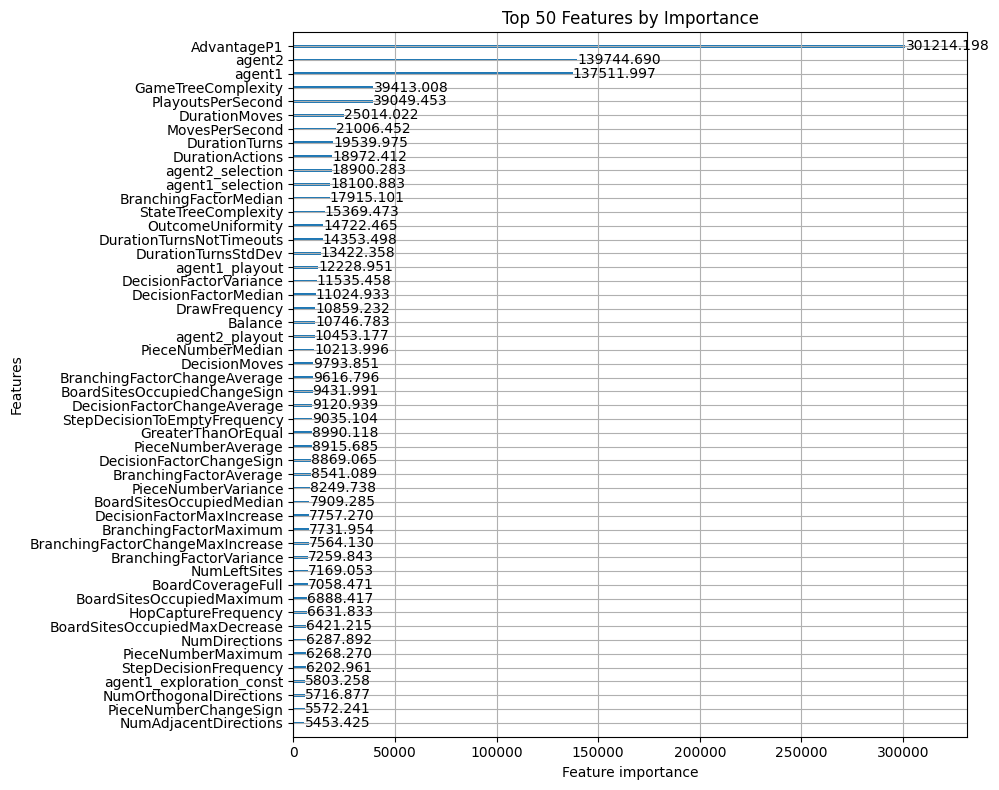

Fold 4 - RMSE: 0.43764475737736813
Fold 5


[100]	valid_0's rmse: 0.519082


[200]	valid_0's rmse: 0.496964


[300]	valid_0's rmse: 0.4843


[400]	valid_0's rmse: 0.476201


[500]	valid_0's rmse: 0.470842


[600]	valid_0's rmse: 0.466878


[700]	valid_0's rmse: 0.463416


[800]	valid_0's rmse: 0.460487


[900]	valid_0's rmse: 0.458286


[1000]	valid_0's rmse: 0.456212


[1100]	valid_0's rmse: 0.454171


[1200]	valid_0's rmse: 0.45255


[1300]	valid_0's rmse: 0.45144


[1400]	valid_0's rmse: 0.450185


[1500]	valid_0's rmse: 0.449333


[1600]	valid_0's rmse: 0.448602


[1700]	valid_0's rmse: 0.447665


[1800]	valid_0's rmse: 0.446789


[1900]	valid_0's rmse: 0.446038


[2000]	valid_0's rmse: 0.445498


[2100]	valid_0's rmse: 0.444744


[2200]	valid_0's rmse: 0.44431


[2300]	valid_0's rmse: 0.443752


[2400]	valid_0's rmse: 0.443308


[2500]	valid_0's rmse: 0.442859


[2600]	valid_0's rmse: 0.442525


[2700]	valid_0's rmse: 0.442215


[2800]	valid_0's rmse: 0.441796


[2900]	valid_0's rmse: 0.44151


[3000]	valid_0's rmse: 0.441272


[3100]	valid_0's rmse: 0.441075


[3200]	valid_0's rmse: 0.440746


[3300]	valid_0's rmse: 0.440482


[3400]	valid_0's rmse: 0.440212


[3500]	valid_0's rmse: 0.439944


[3600]	valid_0's rmse: 0.43987


[3700]	valid_0's rmse: 0.439681


[3800]	valid_0's rmse: 0.43945


[3900]	valid_0's rmse: 0.439239


[4000]	valid_0's rmse: 0.439063


[4100]	valid_0's rmse: 0.438947


[4200]	valid_0's rmse: 0.438744


[4300]	valid_0's rmse: 0.438612


[4400]	valid_0's rmse: 0.438472


[4500]	valid_0's rmse: 0.438344


[4600]	valid_0's rmse: 0.438309


[4700]	valid_0's rmse: 0.438159


[4800]	valid_0's rmse: 0.438142


[4900]	valid_0's rmse: 0.438007


[5000]	valid_0's rmse: 0.437876


[5100]	valid_0's rmse: 0.437783


[5200]	valid_0's rmse: 0.437635


[5300]	valid_0's rmse: 0.437574


[5400]	valid_0's rmse: 0.437489


[5500]	valid_0's rmse: 0.437398


[5600]	valid_0's rmse: 0.437335


[5700]	valid_0's rmse: 0.437281


[5800]	valid_0's rmse: 0.437158


[5900]	valid_0's rmse: 0.437054


[6000]	valid_0's rmse: 0.436965


[6100]	valid_0's rmse: 0.436842


[6200]	valid_0's rmse: 0.43674


[6300]	valid_0's rmse: 0.436658


[6400]	valid_0's rmse: 0.436689


[6500]	valid_0's rmse: 0.436645


[6600]	valid_0's rmse: 0.436588


[6700]	valid_0's rmse: 0.436549


[6800]	valid_0's rmse: 0.436376


[6900]	valid_0's rmse: 0.436343


[7000]	valid_0's rmse: 0.436235


[7100]	valid_0's rmse: 0.436191


[7200]	valid_0's rmse: 0.43613


[7300]	valid_0's rmse: 0.436127


[7400]	valid_0's rmse: 0.436085


[7500]	valid_0's rmse: 0.436044


[7600]	valid_0's rmse: 0.435963


[7700]	valid_0's rmse: 0.435945


[7800]	valid_0's rmse: 0.435884


[7900]	valid_0's rmse: 0.435834


[8000]	valid_0's rmse: 0.435746


[8100]	valid_0's rmse: 0.435704


[8200]	valid_0's rmse: 0.435669


[8300]	valid_0's rmse: 0.435676


[8400]	valid_0's rmse: 0.435702


[8500]	valid_0's rmse: 0.435607


[8600]	valid_0's rmse: 0.435526


[8700]	valid_0's rmse: 0.435494


[8800]	valid_0's rmse: 0.435501


[8900]	valid_0's rmse: 0.435443


[9000]	valid_0's rmse: 0.435461


[9100]	valid_0's rmse: 0.435466


[9200]	valid_0's rmse: 0.435406


[9300]	valid_0's rmse: 0.435383


[9400]	valid_0's rmse: 0.435335


[9500]	valid_0's rmse: 0.43532


[9600]	valid_0's rmse: 0.435297


[9700]	valid_0's rmse: 0.435259


[9800]	valid_0's rmse: 0.435205


[9900]	valid_0's rmse: 0.435184


[10000]	valid_0's rmse: 0.435197


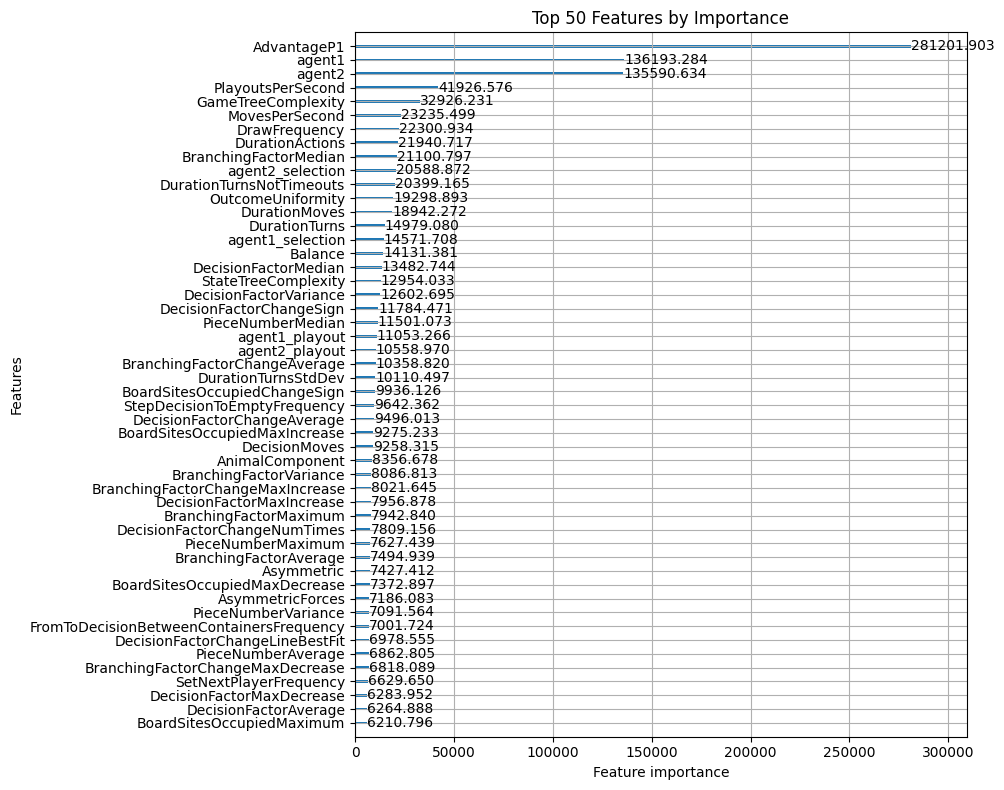

Fold 5 - RMSE: 0.43450979264563083
List of oof scores: [0.40996211533116306, 0.4019397155823597, 0.4324641388745906, 0.43764475737736813, 0.43450979264563083]
Average oof score: 0.42330410396222246


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.502979


[200]	valid_0's rmse: 0.479643


[300]	valid_0's rmse: 0.4681


[400]	valid_0's rmse: 0.461319


[500]	valid_0's rmse: 0.456172


[600]	valid_0's rmse: 0.451878


[700]	valid_0's rmse: 0.448845


[800]	valid_0's rmse: 0.446691


[900]	valid_0's rmse: 0.444909


[1000]	valid_0's rmse: 0.44329


[1100]	valid_0's rmse: 0.441878


[1200]	valid_0's rmse: 0.440936


[1300]	valid_0's rmse: 0.439898


[1400]	valid_0's rmse: 0.439176


[1500]	valid_0's rmse: 0.43849


[1600]	valid_0's rmse: 0.437791


[1700]	valid_0's rmse: 0.437193


[1800]	valid_0's rmse: 0.436585


[1900]	valid_0's rmse: 0.435945


[2000]	valid_0's rmse: 0.435534


[2100]	valid_0's rmse: 0.435192


[2200]	valid_0's rmse: 0.434871


[2300]	valid_0's rmse: 0.434483


[2400]	valid_0's rmse: 0.43403


[2500]	valid_0's rmse: 0.433748


[2600]	valid_0's rmse: 0.433363


[2700]	valid_0's rmse: 0.433149


[2800]	valid_0's rmse: 0.432819


[2900]	valid_0's rmse: 0.432632


[3000]	valid_0's rmse: 0.432513


[3100]	valid_0's rmse: 0.432269


[3200]	valid_0's rmse: 0.432019


[3300]	valid_0's rmse: 0.431866


[3400]	valid_0's rmse: 0.431724


[3500]	valid_0's rmse: 0.431507


[3600]	valid_0's rmse: 0.431442


[3700]	valid_0's rmse: 0.431285


[3800]	valid_0's rmse: 0.431034


[3900]	valid_0's rmse: 0.430932


[4000]	valid_0's rmse: 0.430717


[4100]	valid_0's rmse: 0.430594


[4200]	valid_0's rmse: 0.43056


[4300]	valid_0's rmse: 0.430502


[4400]	valid_0's rmse: 0.430417


[4500]	valid_0's rmse: 0.430296


[4600]	valid_0's rmse: 0.430157


[4700]	valid_0's rmse: 0.430003


[4800]	valid_0's rmse: 0.429929


[4900]	valid_0's rmse: 0.429791


[5000]	valid_0's rmse: 0.42966


[5100]	valid_0's rmse: 0.429588


[5200]	valid_0's rmse: 0.429573


[5300]	valid_0's rmse: 0.429515


[5400]	valid_0's rmse: 0.429483


[5500]	valid_0's rmse: 0.429463


[5600]	valid_0's rmse: 0.42938


[5700]	valid_0's rmse: 0.429356


[5800]	valid_0's rmse: 0.429245


[5900]	valid_0's rmse: 0.429235


[6000]	valid_0's rmse: 0.429196


[6100]	valid_0's rmse: 0.429185


[6200]	valid_0's rmse: 0.429141


[6300]	valid_0's rmse: 0.429082


[6400]	valid_0's rmse: 0.429019


[6500]	valid_0's rmse: 0.429017


[6600]	valid_0's rmse: 0.42892


[6700]	valid_0's rmse: 0.428894


[6800]	valid_0's rmse: 0.42878


[6900]	valid_0's rmse: 0.42874


[7000]	valid_0's rmse: 0.42873


[7100]	valid_0's rmse: 0.428763


[7200]	valid_0's rmse: 0.428875


[7300]	valid_0's rmse: 0.428826


[7400]	valid_0's rmse: 0.428786


[7500]	valid_0's rmse: 0.428799


[7600]	valid_0's rmse: 0.428786


[7700]	valid_0's rmse: 0.428752


[7800]	valid_0's rmse: 0.428701


[7900]	valid_0's rmse: 0.428703


[8000]	valid_0's rmse: 0.428602


[8100]	valid_0's rmse: 0.428556


[8200]	valid_0's rmse: 0.428526


[8300]	valid_0's rmse: 0.428409


[8400]	valid_0's rmse: 0.4284


[8500]	valid_0's rmse: 0.428392


[8600]	valid_0's rmse: 0.428399


[8700]	valid_0's rmse: 0.428335


[8800]	valid_0's rmse: 0.428317


[8900]	valid_0's rmse: 0.428312


[9000]	valid_0's rmse: 0.428294


[9100]	valid_0's rmse: 0.428272


[9200]	valid_0's rmse: 0.42822


[9300]	valid_0's rmse: 0.428204


[9400]	valid_0's rmse: 0.428153


[9500]	valid_0's rmse: 0.428214


[9600]	valid_0's rmse: 0.428231


[9700]	valid_0's rmse: 0.42827


[9800]	valid_0's rmse: 0.428203


[9900]	valid_0's rmse: 0.428194


[10000]	valid_0's rmse: 0.428214


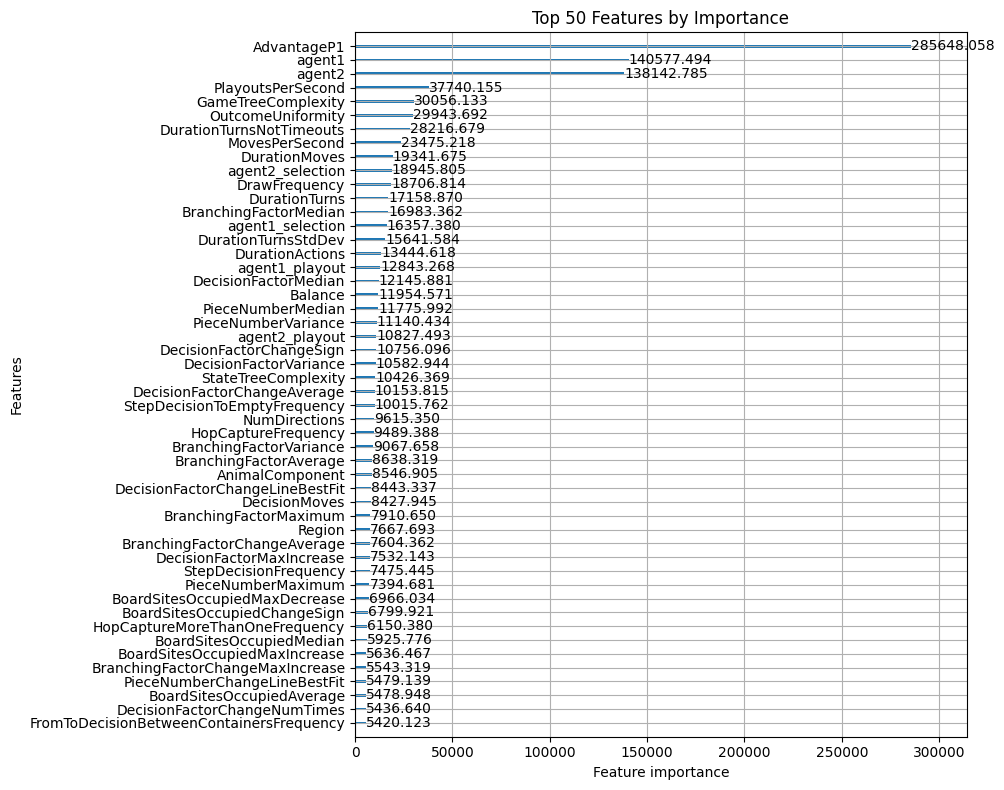

Fold 1 - RMSE: 0.4276381800110143
Fold 2


[100]	valid_0's rmse: 0.505561


[200]	valid_0's rmse: 0.480798


[300]	valid_0's rmse: 0.466569


[400]	valid_0's rmse: 0.457176


[500]	valid_0's rmse: 0.451462


[600]	valid_0's rmse: 0.446306


[700]	valid_0's rmse: 0.442371


[800]	valid_0's rmse: 0.439859


[900]	valid_0's rmse: 0.437237


[1000]	valid_0's rmse: 0.435129


[1100]	valid_0's rmse: 0.433082


[1200]	valid_0's rmse: 0.431484


[1300]	valid_0's rmse: 0.430272


[1400]	valid_0's rmse: 0.429025


[1500]	valid_0's rmse: 0.428119


[1600]	valid_0's rmse: 0.427418


[1700]	valid_0's rmse: 0.426522


[1800]	valid_0's rmse: 0.425643


[1900]	valid_0's rmse: 0.425105


[2000]	valid_0's rmse: 0.424493


[2100]	valid_0's rmse: 0.423849


[2200]	valid_0's rmse: 0.423275


[2300]	valid_0's rmse: 0.422745


[2400]	valid_0's rmse: 0.422334


[2500]	valid_0's rmse: 0.421858


[2600]	valid_0's rmse: 0.421254


[2700]	valid_0's rmse: 0.420886


[2800]	valid_0's rmse: 0.420623


[2900]	valid_0's rmse: 0.420179


[3000]	valid_0's rmse: 0.419787


[3100]	valid_0's rmse: 0.419508


[3200]	valid_0's rmse: 0.419131


[3300]	valid_0's rmse: 0.418829


[3400]	valid_0's rmse: 0.41854


[3500]	valid_0's rmse: 0.418281


[3600]	valid_0's rmse: 0.418117


[3700]	valid_0's rmse: 0.417956


[3800]	valid_0's rmse: 0.417769


[3900]	valid_0's rmse: 0.417466


[4000]	valid_0's rmse: 0.417264


[4100]	valid_0's rmse: 0.417012


[4200]	valid_0's rmse: 0.416852


[4300]	valid_0's rmse: 0.416728


[4400]	valid_0's rmse: 0.416597


[4500]	valid_0's rmse: 0.416364


[4600]	valid_0's rmse: 0.416267


[4700]	valid_0's rmse: 0.416166


[4800]	valid_0's rmse: 0.416092


[4900]	valid_0's rmse: 0.416009


[5000]	valid_0's rmse: 0.415879


[5100]	valid_0's rmse: 0.415802


[5200]	valid_0's rmse: 0.415755


[5300]	valid_0's rmse: 0.415638


[5400]	valid_0's rmse: 0.415473


[5500]	valid_0's rmse: 0.415488


[5600]	valid_0's rmse: 0.415312


[5700]	valid_0's rmse: 0.415251


[5800]	valid_0's rmse: 0.415153


[5900]	valid_0's rmse: 0.415059


[6000]	valid_0's rmse: 0.414943


[6100]	valid_0's rmse: 0.41486


[6200]	valid_0's rmse: 0.41475


[6300]	valid_0's rmse: 0.414742


[6400]	valid_0's rmse: 0.414652


[6500]	valid_0's rmse: 0.414653


[6600]	valid_0's rmse: 0.414626


[6700]	valid_0's rmse: 0.414582


[6800]	valid_0's rmse: 0.414579


[6900]	valid_0's rmse: 0.414517


[7000]	valid_0's rmse: 0.414507


[7100]	valid_0's rmse: 0.414456


[7200]	valid_0's rmse: 0.41434


[7300]	valid_0's rmse: 0.414285


[7400]	valid_0's rmse: 0.414242


[7500]	valid_0's rmse: 0.414175


[7600]	valid_0's rmse: 0.414117


[7700]	valid_0's rmse: 0.414066


[7800]	valid_0's rmse: 0.414


[7900]	valid_0's rmse: 0.413932


[8000]	valid_0's rmse: 0.413855


[8100]	valid_0's rmse: 0.413809


[8200]	valid_0's rmse: 0.413795


[8300]	valid_0's rmse: 0.413739


[8400]	valid_0's rmse: 0.413686


[8500]	valid_0's rmse: 0.413697


[8600]	valid_0's rmse: 0.413627


[8700]	valid_0's rmse: 0.413587


[8800]	valid_0's rmse: 0.413543


[8900]	valid_0's rmse: 0.413504


[9000]	valid_0's rmse: 0.413479


[9100]	valid_0's rmse: 0.413442


[9200]	valid_0's rmse: 0.413422


[9300]	valid_0's rmse: 0.413375


[9400]	valid_0's rmse: 0.413383


[9500]	valid_0's rmse: 0.413366


[9600]	valid_0's rmse: 0.413308


[9700]	valid_0's rmse: 0.413298


[9800]	valid_0's rmse: 0.413258


[9900]	valid_0's rmse: 0.413184


[10000]	valid_0's rmse: 0.413147


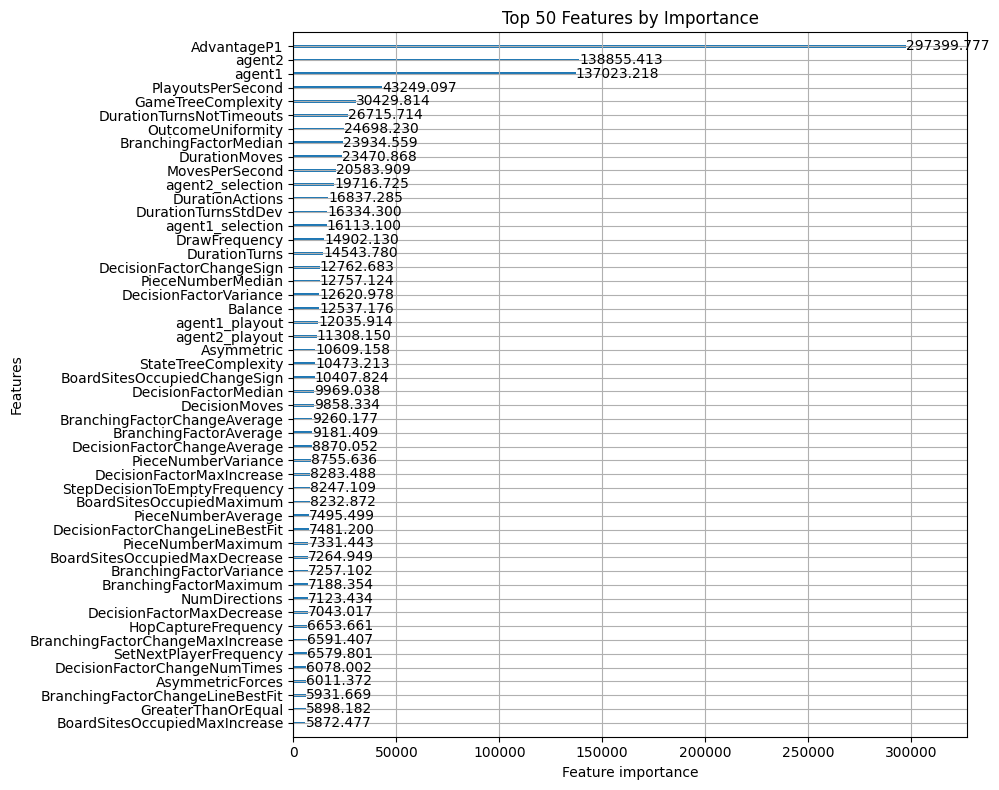

Fold 2 - RMSE: 0.41272579428588085
Fold 3


[100]	valid_0's rmse: 0.495319


[200]	valid_0's rmse: 0.47119


[300]	valid_0's rmse: 0.460551


[400]	valid_0's rmse: 0.453012


[500]	valid_0's rmse: 0.448046


[600]	valid_0's rmse: 0.444767


[700]	valid_0's rmse: 0.442274


[800]	valid_0's rmse: 0.440214


[900]	valid_0's rmse: 0.438673


[1000]	valid_0's rmse: 0.43724


[1100]	valid_0's rmse: 0.435824


[1200]	valid_0's rmse: 0.434599


[1300]	valid_0's rmse: 0.433678


[1400]	valid_0's rmse: 0.432719


[1500]	valid_0's rmse: 0.431926


[1600]	valid_0's rmse: 0.431097


[1700]	valid_0's rmse: 0.430582


[1800]	valid_0's rmse: 0.430107


[1900]	valid_0's rmse: 0.429679


[2000]	valid_0's rmse: 0.429396


[2100]	valid_0's rmse: 0.428916


[2200]	valid_0's rmse: 0.428537


[2300]	valid_0's rmse: 0.428201


[2400]	valid_0's rmse: 0.427881


[2500]	valid_0's rmse: 0.427444


[2600]	valid_0's rmse: 0.427138


[2700]	valid_0's rmse: 0.42686


[2800]	valid_0's rmse: 0.426529


[2900]	valid_0's rmse: 0.426261


[3000]	valid_0's rmse: 0.425986


[3100]	valid_0's rmse: 0.425748


[3200]	valid_0's rmse: 0.42555


[3300]	valid_0's rmse: 0.42534


[3400]	valid_0's rmse: 0.425036


[3500]	valid_0's rmse: 0.424828


[3600]	valid_0's rmse: 0.424684


[3700]	valid_0's rmse: 0.424516


[3800]	valid_0's rmse: 0.42443


[3900]	valid_0's rmse: 0.42413


[4000]	valid_0's rmse: 0.423934


[4100]	valid_0's rmse: 0.423748


[4200]	valid_0's rmse: 0.423671


[4300]	valid_0's rmse: 0.423572


[4400]	valid_0's rmse: 0.423431


[4500]	valid_0's rmse: 0.423315


[4600]	valid_0's rmse: 0.423197


[4700]	valid_0's rmse: 0.423025


[4800]	valid_0's rmse: 0.422976


[4900]	valid_0's rmse: 0.422988


[5000]	valid_0's rmse: 0.422956


[5100]	valid_0's rmse: 0.422894


[5200]	valid_0's rmse: 0.42289


[5300]	valid_0's rmse: 0.422822


[5400]	valid_0's rmse: 0.422746


[5500]	valid_0's rmse: 0.422651


[5600]	valid_0's rmse: 0.422616


[5700]	valid_0's rmse: 0.422606


[5800]	valid_0's rmse: 0.422575


[5900]	valid_0's rmse: 0.422516


[6000]	valid_0's rmse: 0.422541


[6100]	valid_0's rmse: 0.422473


[6200]	valid_0's rmse: 0.42242


[6300]	valid_0's rmse: 0.422364


[6400]	valid_0's rmse: 0.422336


[6500]	valid_0's rmse: 0.422287


[6600]	valid_0's rmse: 0.42228


[6700]	valid_0's rmse: 0.422293


[6800]	valid_0's rmse: 0.4223


[6900]	valid_0's rmse: 0.422243


[7000]	valid_0's rmse: 0.422146


[7100]	valid_0's rmse: 0.422127


[7200]	valid_0's rmse: 0.422085


[7300]	valid_0's rmse: 0.422066


[7400]	valid_0's rmse: 0.422036


[7500]	valid_0's rmse: 0.421918


[7600]	valid_0's rmse: 0.421924


[7700]	valid_0's rmse: 0.421917


[7800]	valid_0's rmse: 0.421878


[7900]	valid_0's rmse: 0.421808


[8000]	valid_0's rmse: 0.421817


[8100]	valid_0's rmse: 0.421765


[8200]	valid_0's rmse: 0.421814


[8300]	valid_0's rmse: 0.421736


[8400]	valid_0's rmse: 0.421712


[8500]	valid_0's rmse: 0.421691


[8600]	valid_0's rmse: 0.421621


[8700]	valid_0's rmse: 0.421582


[8800]	valid_0's rmse: 0.421545


[8900]	valid_0's rmse: 0.421585


[9000]	valid_0's rmse: 0.42158


[9100]	valid_0's rmse: 0.421585


[9200]	valid_0's rmse: 0.421588


[9300]	valid_0's rmse: 0.421567


[9400]	valid_0's rmse: 0.421544


[9500]	valid_0's rmse: 0.42154


[9600]	valid_0's rmse: 0.421509


[9700]	valid_0's rmse: 0.421555


[9800]	valid_0's rmse: 0.421479


[9900]	valid_0's rmse: 0.421469


[10000]	valid_0's rmse: 0.421451


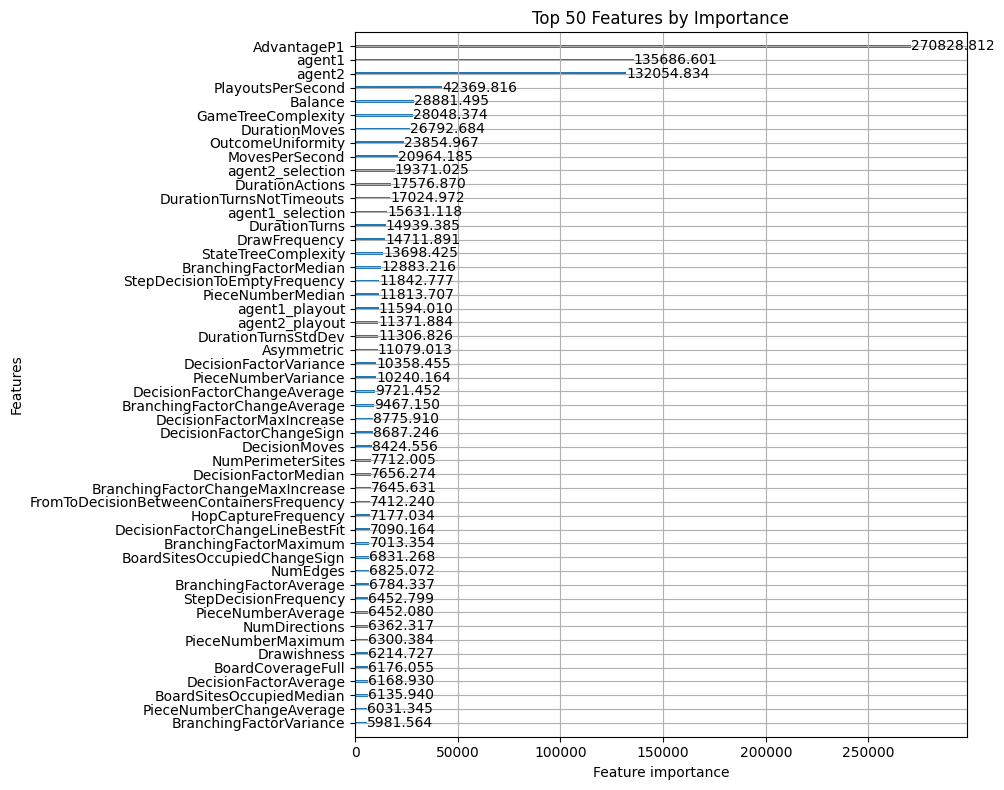

Fold 3 - RMSE: 0.4210139529596395
Fold 4


[100]	valid_0's rmse: 0.486272


[200]	valid_0's rmse: 0.466991


[300]	valid_0's rmse: 0.455517


[400]	valid_0's rmse: 0.449378


[500]	valid_0's rmse: 0.445474


[600]	valid_0's rmse: 0.442185


[700]	valid_0's rmse: 0.439412


[800]	valid_0's rmse: 0.437428


[900]	valid_0's rmse: 0.435612


[1000]	valid_0's rmse: 0.434041


[1100]	valid_0's rmse: 0.432576


[1200]	valid_0's rmse: 0.431543


[1300]	valid_0's rmse: 0.430807


[1400]	valid_0's rmse: 0.429824


[1500]	valid_0's rmse: 0.429223


[1600]	valid_0's rmse: 0.428517


[1700]	valid_0's rmse: 0.427916


[1800]	valid_0's rmse: 0.427506


[1900]	valid_0's rmse: 0.426997


[2000]	valid_0's rmse: 0.426591


[2100]	valid_0's rmse: 0.425963


[2200]	valid_0's rmse: 0.425526


[2300]	valid_0's rmse: 0.425143


[2400]	valid_0's rmse: 0.42489


[2500]	valid_0's rmse: 0.424469


[2600]	valid_0's rmse: 0.424262


[2700]	valid_0's rmse: 0.423989


[2800]	valid_0's rmse: 0.423776


[2900]	valid_0's rmse: 0.423441


[3000]	valid_0's rmse: 0.42329


[3100]	valid_0's rmse: 0.423083


[3200]	valid_0's rmse: 0.422977


[3300]	valid_0's rmse: 0.422758


[3400]	valid_0's rmse: 0.422543


[3500]	valid_0's rmse: 0.422301


[3600]	valid_0's rmse: 0.422092


[3700]	valid_0's rmse: 0.421978


[3800]	valid_0's rmse: 0.421823


[3900]	valid_0's rmse: 0.42174


[4000]	valid_0's rmse: 0.421646


[4100]	valid_0's rmse: 0.421681


[4200]	valid_0's rmse: 0.421571


[4300]	valid_0's rmse: 0.421461


[4400]	valid_0's rmse: 0.421336


[4500]	valid_0's rmse: 0.421256


[4600]	valid_0's rmse: 0.421209


[4700]	valid_0's rmse: 0.421107


[4800]	valid_0's rmse: 0.421077


[4900]	valid_0's rmse: 0.420941


[5000]	valid_0's rmse: 0.42083


[5100]	valid_0's rmse: 0.42076


[5200]	valid_0's rmse: 0.420646


[5300]	valid_0's rmse: 0.420544


[5400]	valid_0's rmse: 0.42044


[5500]	valid_0's rmse: 0.420334


[5600]	valid_0's rmse: 0.420286


[5700]	valid_0's rmse: 0.4202


[5800]	valid_0's rmse: 0.420124


[5900]	valid_0's rmse: 0.420116


[6000]	valid_0's rmse: 0.42008


[6100]	valid_0's rmse: 0.420014


[6200]	valid_0's rmse: 0.419962


[6300]	valid_0's rmse: 0.419891


[6400]	valid_0's rmse: 0.419824


[6500]	valid_0's rmse: 0.419728


[6600]	valid_0's rmse: 0.419676


[6700]	valid_0's rmse: 0.41959


[6800]	valid_0's rmse: 0.419513


[6900]	valid_0's rmse: 0.419368


[7000]	valid_0's rmse: 0.419364


[7100]	valid_0's rmse: 0.41931


[7200]	valid_0's rmse: 0.41933


[7300]	valid_0's rmse: 0.419255


[7400]	valid_0's rmse: 0.41914


[7500]	valid_0's rmse: 0.41909


[7600]	valid_0's rmse: 0.419061


[7700]	valid_0's rmse: 0.419023


[7800]	valid_0's rmse: 0.419002


[7900]	valid_0's rmse: 0.418989


[8000]	valid_0's rmse: 0.418936


[8100]	valid_0's rmse: 0.418942


[8200]	valid_0's rmse: 0.418872


[8300]	valid_0's rmse: 0.418836


[8400]	valid_0's rmse: 0.418827


[8500]	valid_0's rmse: 0.418813


[8600]	valid_0's rmse: 0.41878


[8700]	valid_0's rmse: 0.418806


[8800]	valid_0's rmse: 0.418824


[8900]	valid_0's rmse: 0.418805


[9000]	valid_0's rmse: 0.418789


[9100]	valid_0's rmse: 0.41877


[9200]	valid_0's rmse: 0.418728


[9300]	valid_0's rmse: 0.41873


[9400]	valid_0's rmse: 0.4187


[9500]	valid_0's rmse: 0.418687


[9600]	valid_0's rmse: 0.41871


[9700]	valid_0's rmse: 0.418684


[9800]	valid_0's rmse: 0.418622


[9900]	valid_0's rmse: 0.418605


[10000]	valid_0's rmse: 0.418605


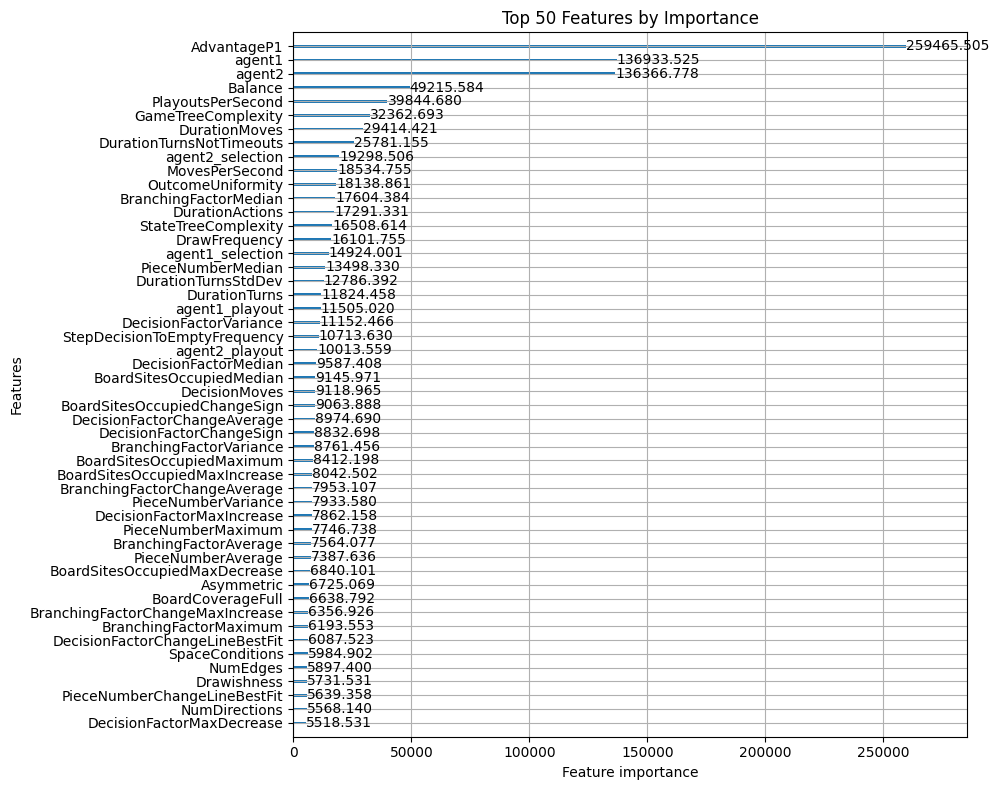

Fold 4 - RMSE: 0.4178323394935366
Fold 5


[100]	valid_0's rmse: 0.510495


[200]	valid_0's rmse: 0.489144


[300]	valid_0's rmse: 0.477183


[400]	valid_0's rmse: 0.468853


[500]	valid_0's rmse: 0.462873


[600]	valid_0's rmse: 0.457909


[700]	valid_0's rmse: 0.454501


[800]	valid_0's rmse: 0.451316


[900]	valid_0's rmse: 0.448909


[1000]	valid_0's rmse: 0.446538


[1100]	valid_0's rmse: 0.444291


[1200]	valid_0's rmse: 0.442723


[1300]	valid_0's rmse: 0.441221


[1400]	valid_0's rmse: 0.440339


[1500]	valid_0's rmse: 0.439356


[1600]	valid_0's rmse: 0.438354


[1700]	valid_0's rmse: 0.437736


[1800]	valid_0's rmse: 0.436868


[1900]	valid_0's rmse: 0.436316


[2000]	valid_0's rmse: 0.435754


[2100]	valid_0's rmse: 0.435272


[2200]	valid_0's rmse: 0.434789


[2300]	valid_0's rmse: 0.434266


[2400]	valid_0's rmse: 0.433882


[2500]	valid_0's rmse: 0.433445


[2600]	valid_0's rmse: 0.433057


[2700]	valid_0's rmse: 0.432648


[2800]	valid_0's rmse: 0.432306


[2900]	valid_0's rmse: 0.43188


[3000]	valid_0's rmse: 0.431641


[3100]	valid_0's rmse: 0.431364


[3200]	valid_0's rmse: 0.430983


[3300]	valid_0's rmse: 0.430713


[3400]	valid_0's rmse: 0.430408


[3500]	valid_0's rmse: 0.430075


[3600]	valid_0's rmse: 0.429831


[3700]	valid_0's rmse: 0.429767


[3800]	valid_0's rmse: 0.429597


[3900]	valid_0's rmse: 0.429402


[4000]	valid_0's rmse: 0.429336


[4100]	valid_0's rmse: 0.429209


[4200]	valid_0's rmse: 0.429045


[4300]	valid_0's rmse: 0.428896


[4400]	valid_0's rmse: 0.428834


[4500]	valid_0's rmse: 0.428693


[4600]	valid_0's rmse: 0.428652


[4700]	valid_0's rmse: 0.428492


[4800]	valid_0's rmse: 0.428298


[4900]	valid_0's rmse: 0.428185


[5000]	valid_0's rmse: 0.42804


[5100]	valid_0's rmse: 0.427959


[5200]	valid_0's rmse: 0.42782


[5300]	valid_0's rmse: 0.42775


[5400]	valid_0's rmse: 0.427624


[5500]	valid_0's rmse: 0.427511


[5600]	valid_0's rmse: 0.427462


[5700]	valid_0's rmse: 0.42734


[5800]	valid_0's rmse: 0.427285


[5900]	valid_0's rmse: 0.427206


[6000]	valid_0's rmse: 0.427144


[6100]	valid_0's rmse: 0.427122


[6200]	valid_0's rmse: 0.427031


[6300]	valid_0's rmse: 0.427008


[6400]	valid_0's rmse: 0.426974


[6500]	valid_0's rmse: 0.426985


[6600]	valid_0's rmse: 0.426918


[6700]	valid_0's rmse: 0.426791


[6800]	valid_0's rmse: 0.426733


[6900]	valid_0's rmse: 0.426624


[7000]	valid_0's rmse: 0.426554


[7100]	valid_0's rmse: 0.426457


[7200]	valid_0's rmse: 0.426441


[7300]	valid_0's rmse: 0.426428


[7400]	valid_0's rmse: 0.426441


[7500]	valid_0's rmse: 0.426351


[7600]	valid_0's rmse: 0.426342


[7700]	valid_0's rmse: 0.42632


[7800]	valid_0's rmse: 0.42628


[7900]	valid_0's rmse: 0.426248


[8000]	valid_0's rmse: 0.426293


[8100]	valid_0's rmse: 0.426242


[8200]	valid_0's rmse: 0.42624


[8300]	valid_0's rmse: 0.426218


[8400]	valid_0's rmse: 0.42619


[8500]	valid_0's rmse: 0.42612


[8600]	valid_0's rmse: 0.426089


[8700]	valid_0's rmse: 0.426019


[8800]	valid_0's rmse: 0.425981


[8900]	valid_0's rmse: 0.426008


[9000]	valid_0's rmse: 0.425997


[9100]	valid_0's rmse: 0.426012


[9200]	valid_0's rmse: 0.426019


[9300]	valid_0's rmse: 0.426031


[9400]	valid_0's rmse: 0.426018


[9500]	valid_0's rmse: 0.425953


[9600]	valid_0's rmse: 0.42589


[9700]	valid_0's rmse: 0.425897


[9800]	valid_0's rmse: 0.425871


[9900]	valid_0's rmse: 0.425855


[10000]	valid_0's rmse: 0.425808


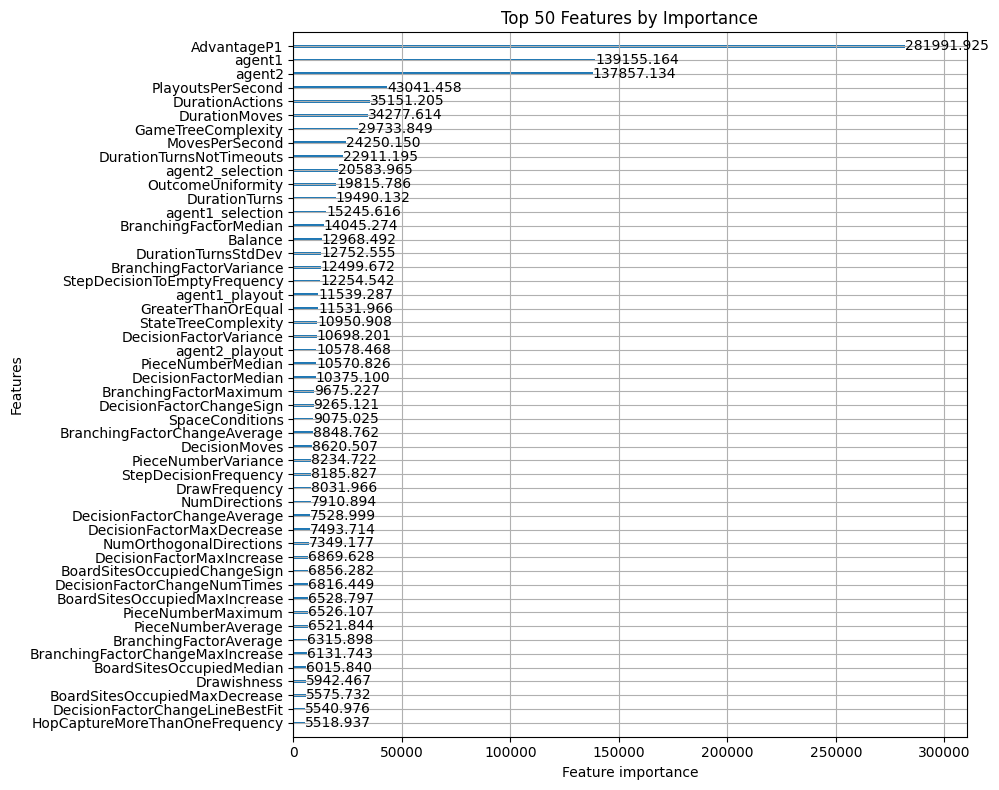

Fold 5 - RMSE: 0.4252818750187865
List of oof scores: [0.4276381800110143, 0.41272579428588085, 0.4210139529596395, 0.4178323394935366, 0.4252818750187865]
Average oof score: 0.4208984283537715


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4222
Score: 0.4485
Score: 0.4360
Score: 0.4339
Score: 0.4036
Average CV1 Score: 0.4288

CV2 OOF Scores:
Score: 0.4100
Score: 0.4019
Score: 0.4325
Score: 0.4376
Score: 0.4345
Average CV2 Score: 0.4233

CV3 OOF Scores:
Score: 0.4276
Score: 0.4127
Score: 0.4210
Score: 0.4178
Score: 0.4253
Average CV3 Score: 0.4209


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

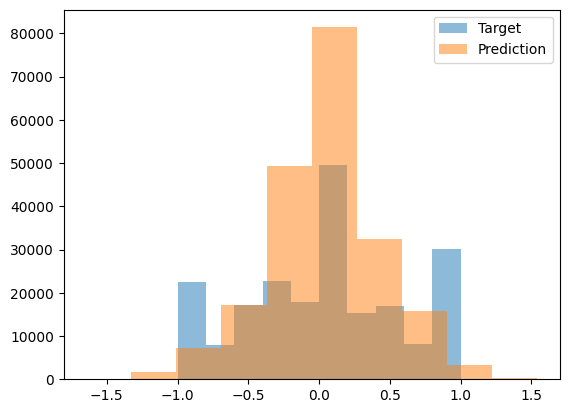

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.148354       │
│ 233235 ┆ -0.185151      │
│ 233236 ┆ -0.003656      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***